In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import scipy.stats as stats
import pandas as pd
import pickle
import os
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler

regions = {0: 'imgs', 1: 'caudate', 2: 'cerebellum', 3: 'frontal_lobe', 4: 'insula', 5: 'occipital_lobe', 6: 'parietal_lobe', 7: 'putamen', 8: 'temporal_lobe', 9: 'thalamus'}
root = '/media/leelabsg-storage1/yein/research/test/'
age_diff_groups = {}
cn_size = 25656
disease_l = 'e780'
disease_u = 'E780'

In [14]:
def bias_correction(true, pred):
    reg = LinearRegression().fit(true.reshape(-1, 1), pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]

    corrected_pred = (pred - beta_0) / beta_1
    return corrected_pred


def bias_correction_standard(true, pred):
    true = np.array(true).reshape(-1, 1)
    pred = np.array(pred).reshape(-1, 1)
    
    # StandardScaler를 사용하여 정규화
    scaler = StandardScaler()
    true_scaled = scaler.fit_transform(true)
    pred_scaled = scaler.transform(pred)
    
    # Linear Regression 모델을 사용하여 예측 차이를 보정
    reg = LinearRegression().fit(true_scaled, pred_scaled)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]
    
    corrected_pred = scaler.inverse_transform((pred_scaled - beta_0) / beta_1)
    
    return corrected_pred

def pickel_load_cn(root):
    map = dict()
    for _, v in regions.items():
        map[v] = {'pred_ages': [],
                 'true_ages': []}

    
    for cv_num in range(4):
        for content in ['pred_ages', 'true_ages']:
            pickel_path = os.path.join(root, str(cv_num), f'{content}.pickle')
            # print(pickel_path)
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file) # cv-split size의 dict (region: age_lists)

            for _, v in regions.items():
                map[v][content].extend(curr_cv[v][0])

    return map

def pickle_load(root, cn=False, alpha=1.0):
    map = {v: {'pred_ages': [], 'true_ages': []} for _, v in regions.items()}

    # true_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickel_path = os.path.join(root, str(cv_num), 'true_ages.pkl')
        if os.path.exists(pickel_path):
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file)  # cv-split size의 dict (region: age_lists)  # age_lists length: 630
                for region, age_list in curr_cv.items():
                    if cn == False:
                        map[region]['true_ages'] = age_list
                    else:
                        map[region]['true_ages'].extend(age_list)
    
    # pred_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickle_path = os.path.join(root, str(cv_num), 'pred_ages.pkl')
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                curr_cv = pickle.load(file)
                for region, age_list in curr_cv.items():
                    if cn == False:
                        map[region]['pred_ages'].append(age_list)
                    else:
                        map[region]['pred_ages'].extend(age_list)
    
    if cn == False:
        for region, _ in map.items():
            pred_ages_lists = map[region]['pred_ages']
            pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
            map[region]['pred_ages'] = pred_avg_age
    for region, age_list in map.items():
        print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))

    

    print("=" * 30)
    return map          

def age_dist_plot(region, cn, disease):
    plt.figure(figsize=(12, 8))
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.6, label='CN', density=True, edgecolor='black', color='#2986cc')
    plt.hist(disease[region]['true_ages'], bins=30, alpha=0.4, label=disease_u, density=True, edgecolor='black', color='#cc0000')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()


def age_plot(data, region):
    true = data[region]['true_ages']
    pred = data[region]['pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def age_plot_corrected(data, region):
    true = data[region]['true_ages']
    pred = data[region]['corrected_pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Corrected Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def calculate_corrected_age_diff_avg(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    avg_diff = np.mean(corrected_pred_ages - true_ages)
    return np.round(avg_diff, 7)

def age_diff_plot(age_diff_dict, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    age_diff_max = max(abs(max(age_diff_dict.values())), abs(min(age_diff_dict.values())))

    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=-age_diff_max, vmax=age_diff_max)

    for region, age_diff in age_diff_dict.items():
        color = cmap(norm(age_diff))
        ax.barh(region, age_diff, color=color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('PAD (years)')

    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD)')
    plt.show()

# 예측 연령 차이 계산
def calculate_age_diff_avg(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(pred_ages - true_ages)

def calculate_age_diff_dist(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = calculate_corrected_age_diff_avg(data, region)

    plt.hist(corrected_pred_ages, bins=30, alpha=0.5, label='Predicted', density=True, edgecolor='black', color='red')
    plt.hist(true_ages, bins=30, alpha=0.5, label='True', density=True, edgecolor='black', color='grey')
    # plt.hist(diff, bins=30, alpha=0.5, label='Difference', density=True, edgecolor='black')
    plt.title('Age Difference Distribution')
    plt.xlabel('Age Difference')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    print(age_diff_dict)
    fig, ax = plt.subplots(figsize=(12, 8))

    # 그룹별 색상 설정
    colors = {
        'CN': 'blue',
        'MCI': 'green',
        'AD': 'red'
    }

    bar_width = 0.2  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_groups[group][region] for region in regions]
        bar_positions = index + i * bar_width
        ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group])

    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD) by Group')
    ax.legend()
    plt.show()

In [8]:
cn_root = root + 'ukb'
cn_ages = pickel_load_cn(cn_root)
disease_root = root + f'ukb_{disease_l}'
disease_ages = pickle_load(disease_root, False)
print(len(cn_ages['imgs']['true_ages']), len(disease_ages['imgs']['true_ages']))

imgs 1605 1605
caudate 1605 1605
cerebellum 1605 1605
frontal_lobe 1605 1605
insula 1605 1605
occipital_lobe 1605 1605
parietal_lobe 1605 1605
putamen 1605 1605
temporal_lobe 1605 1605
thalamus 1605 1605
25656 1605


In [11]:
regions_name = list(regions.values())
ukbb_regions_ages = dict()

for idx, region in enumerate(regions_name):
    print(region)
    ages = {
        'pred': [],
        'true': []
    }
    ukbb_regions_ages.setdefault(region, ages)
    ukbb_regions_ages[region]['pred'].extend(cn_ages[region]['pred_ages'])
    ukbb_regions_ages[region]['true'].extend(cn_ages[region]['true_ages'])
    ukbb_regions_ages[region]['pred'].extend(disease_ages[region]['pred_ages'])
    ukbb_regions_ages[region]['true'].extend(disease_ages[region]['true_ages'])

    true = np.array(ukbb_regions_ages[region]['true'])
    pred = np.array(ukbb_regions_ages[region]['pred'])
    ukbb_regions_ages[region]['corrected_pred'] = bias_correction(true, pred)
    print(len(ukbb_regions_ages[region]), len(ukbb_regions_ages[region]['true']), len(ukbb_regions_ages[region]['pred']), len(ukbb_regions_ages[region]['corrected_pred']))

    cn_ages[region]['corrected_pred_ages'] = ukbb_regions_ages[region]['corrected_pred'][:cn_size]
    disease_ages[region]['corrected_pred_ages'] = ukbb_regions_ages[region]['corrected_pred'][cn_size:]

    print(len(cn_ages[region]['corrected_pred_ages']), len(disease_ages[region]['corrected_pred_ages']))
    print("=" * 20)

imgs
3 27261 27261 27261
25656 1605
caudate
3 27261 27261 27261
25656 1605
cerebellum
3 27261 27261 27261
25656 1605
frontal_lobe
3 27261 27261 27261
25656 1605
insula
3 27261 27261 27261
25656 1605
occipital_lobe
3 27261 27261 27261
25656 1605
parietal_lobe
3 27261 27261 27261
25656 1605
putamen
3 27261 27261 27261
25656 1605
temporal_lobe
3 27261 27261 27261
25656 1605
thalamus
3 27261 27261 27261
25656 1605


In [12]:
cn_ages['imgs']['corrected_pred_ages']

array([75.01858092, 64.49001495, 70.4892069 , ..., 66.68159853,
       64.82746965, 59.38601444])

# age distribution by group

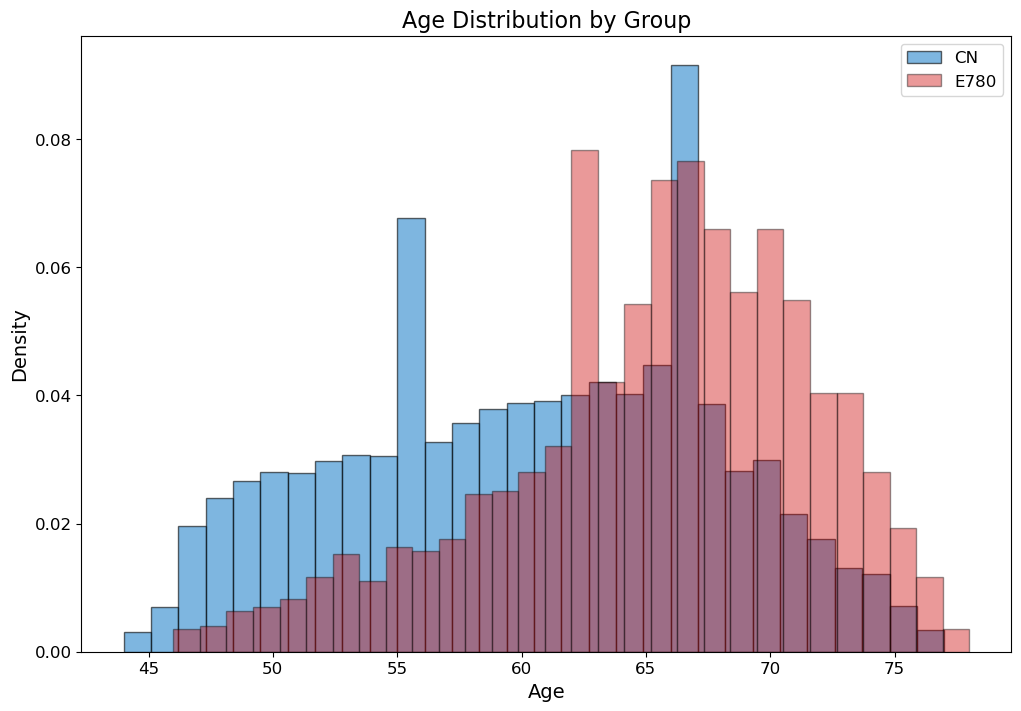

In [15]:
age_dist_plot('imgs', cn_ages, disease_ages)

# CN

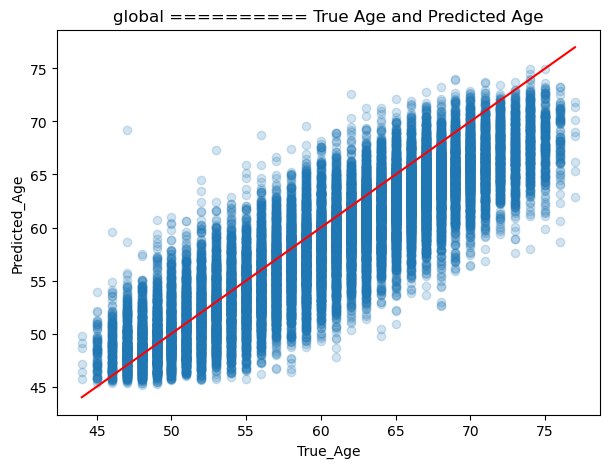

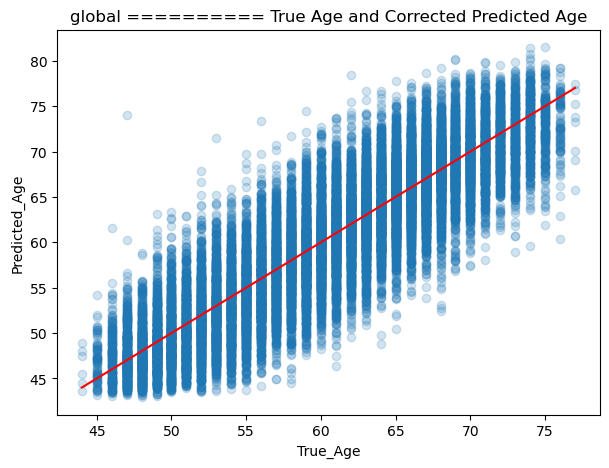

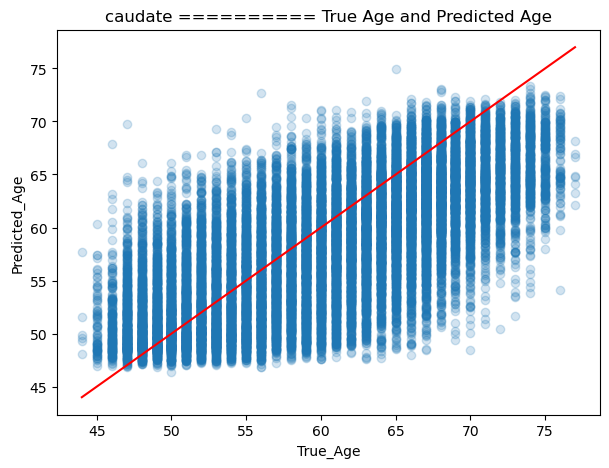

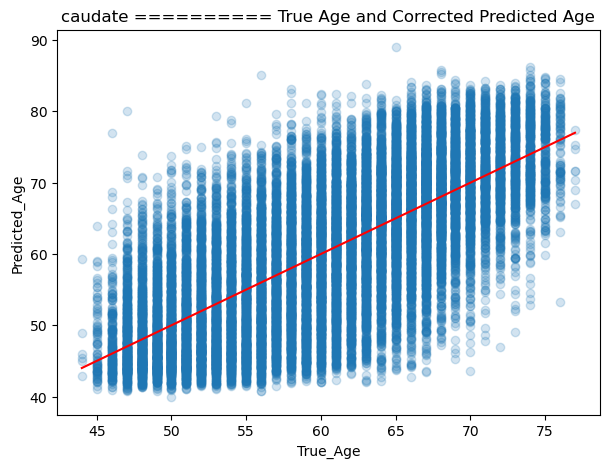

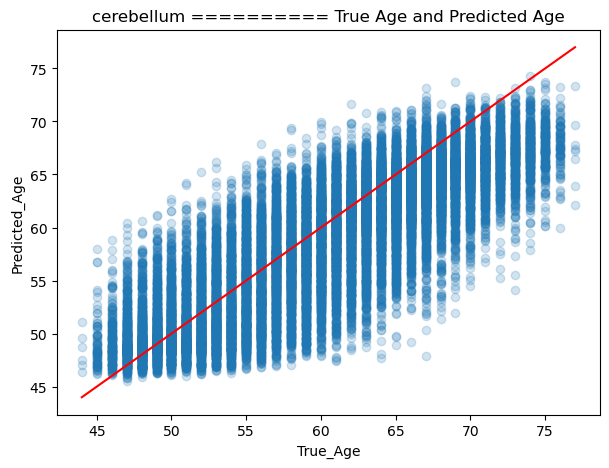

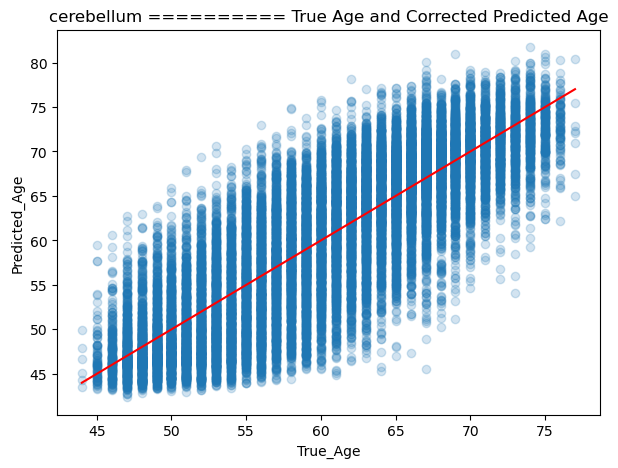

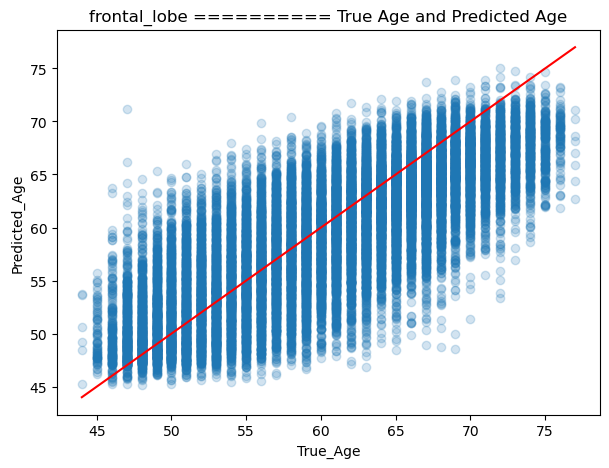

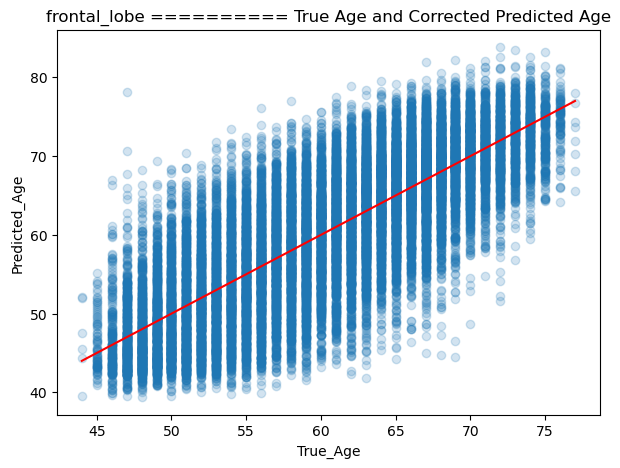

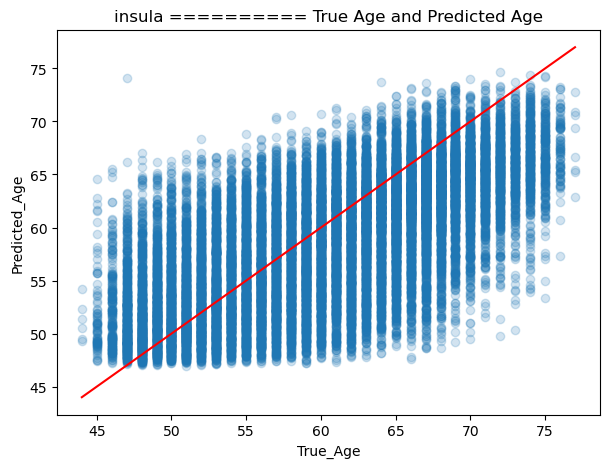

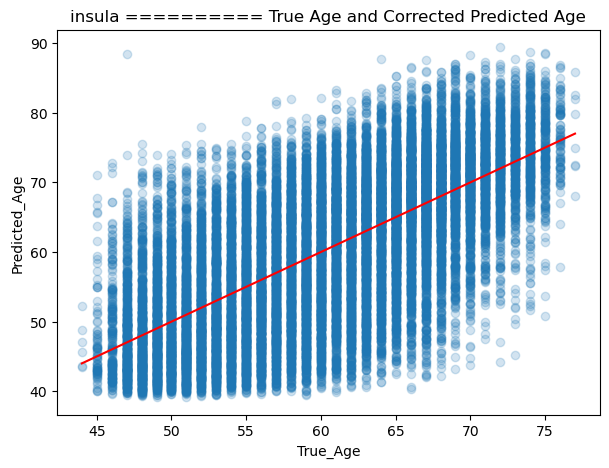

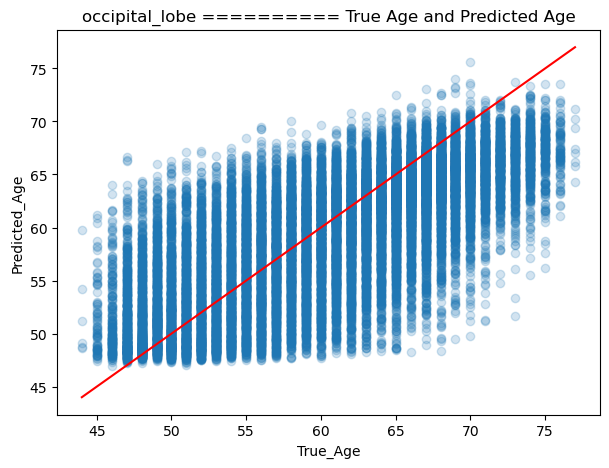

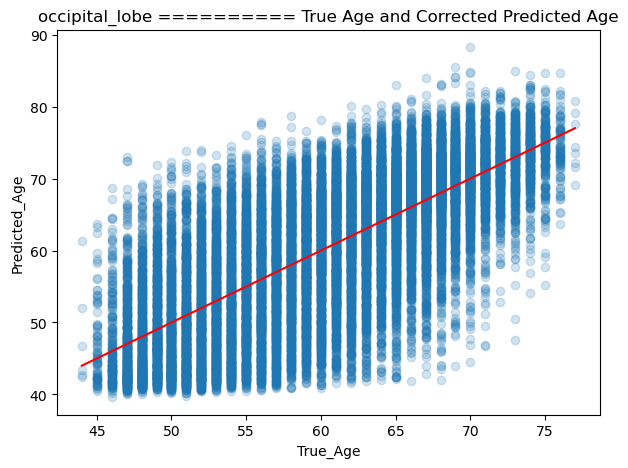

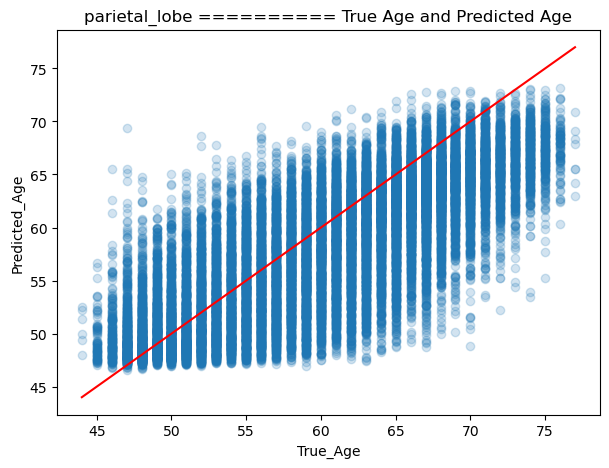

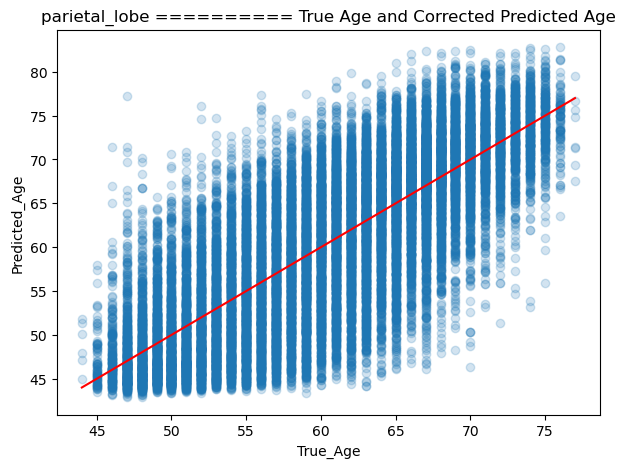

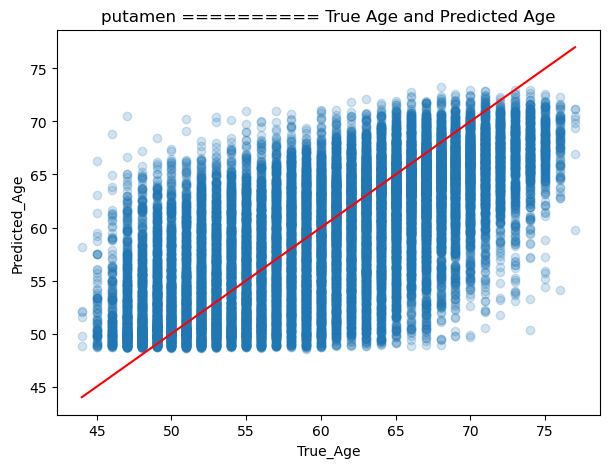

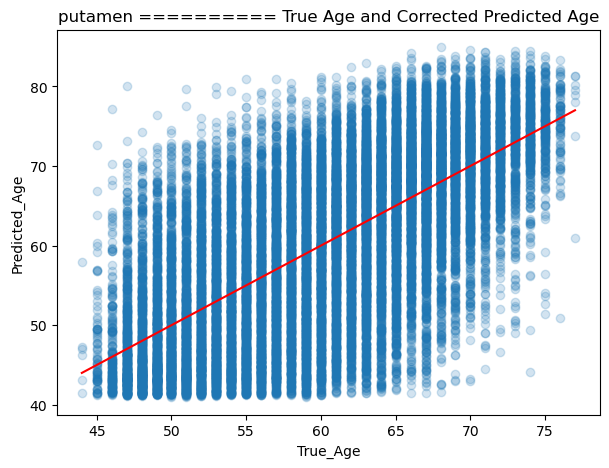

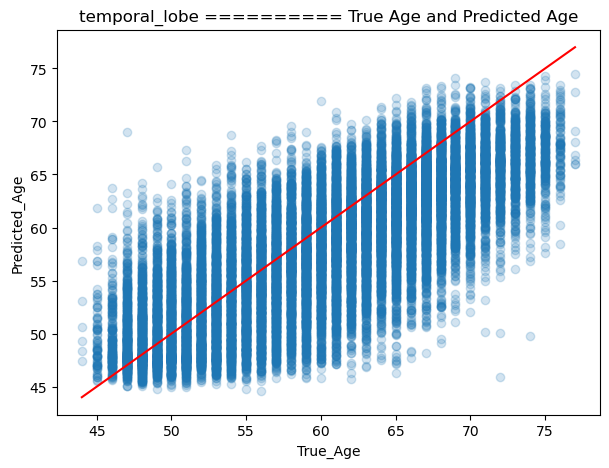

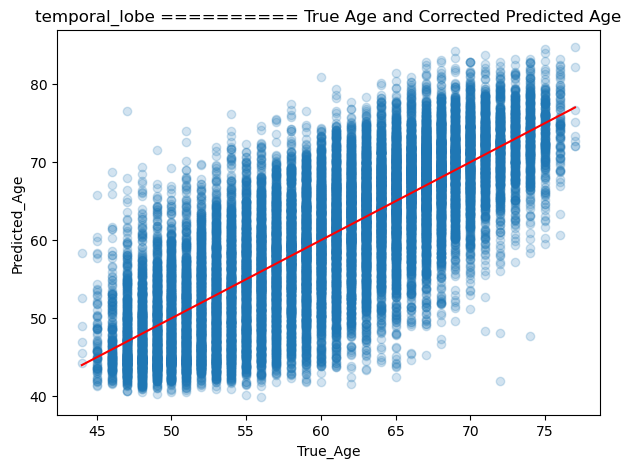

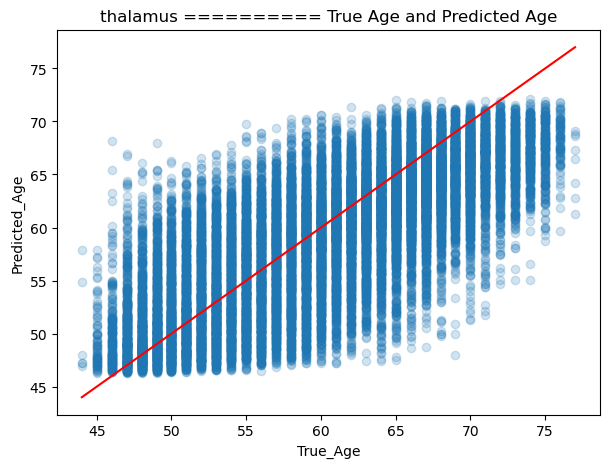

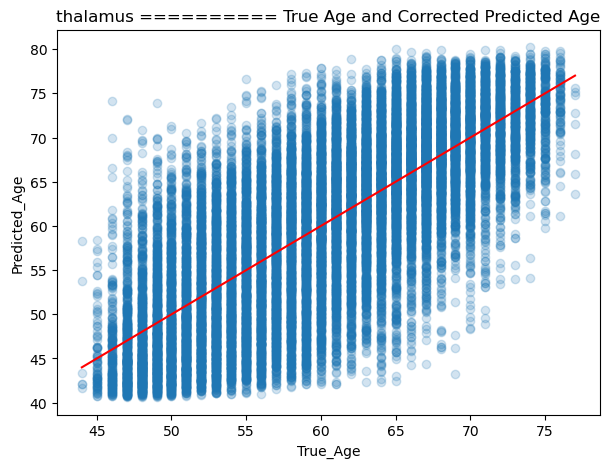

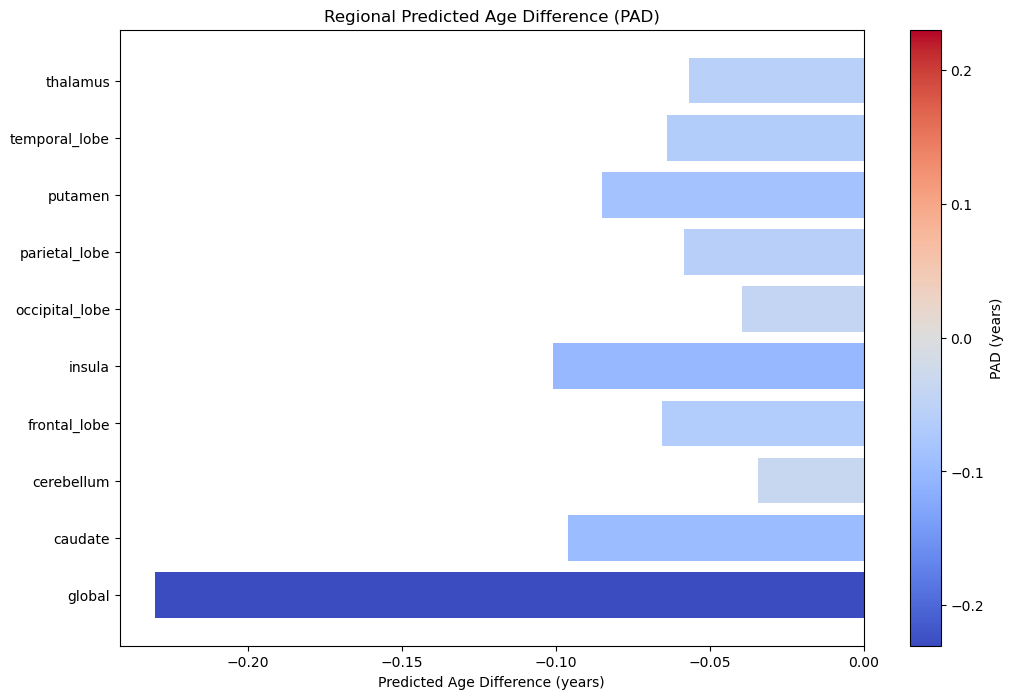

In [35]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_groups = dict()
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    region_n = region
    if region == 'imgs':
        region_n = 'global'
    age_plot(cn_ages, region)
    age_plot_corrected(cn_ages, region)
    age_diff_dict[region_n] = calculate_corrected_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region_n] = age_diff_dict[region_n]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Disease

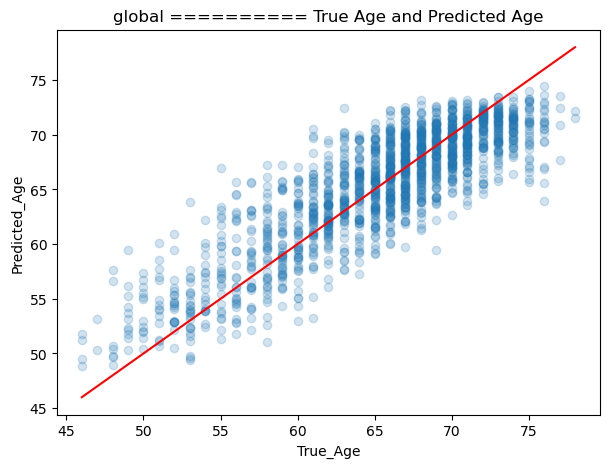

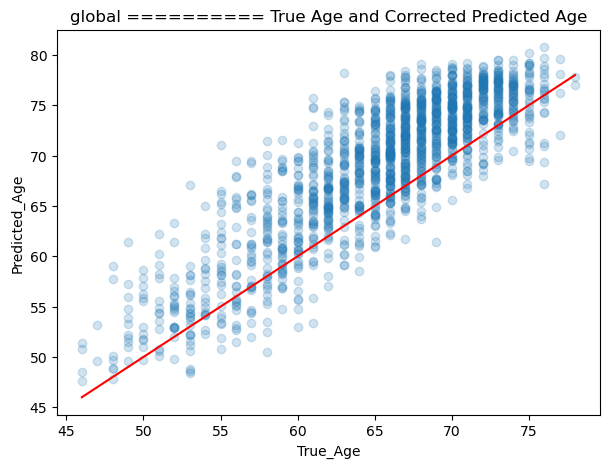

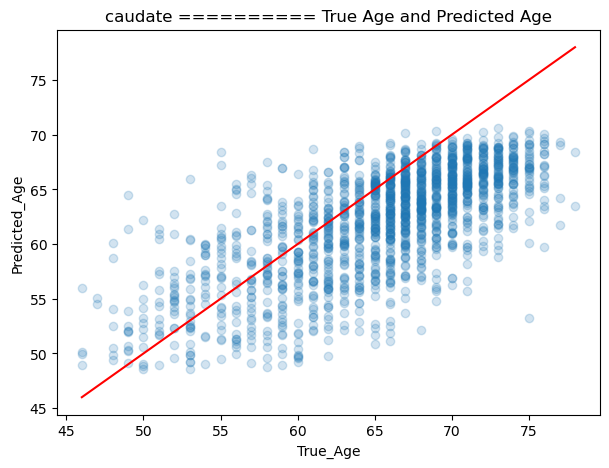

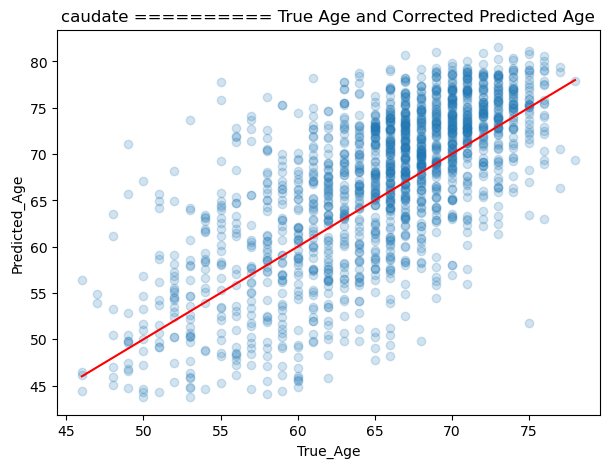

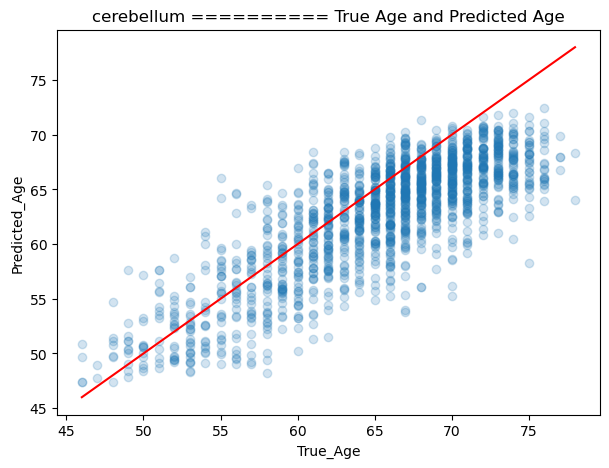

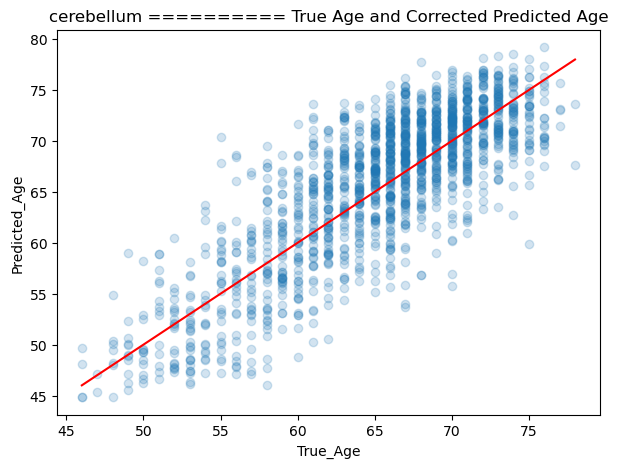

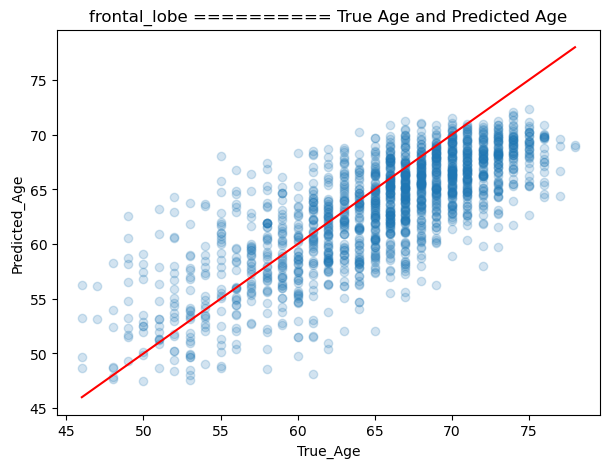

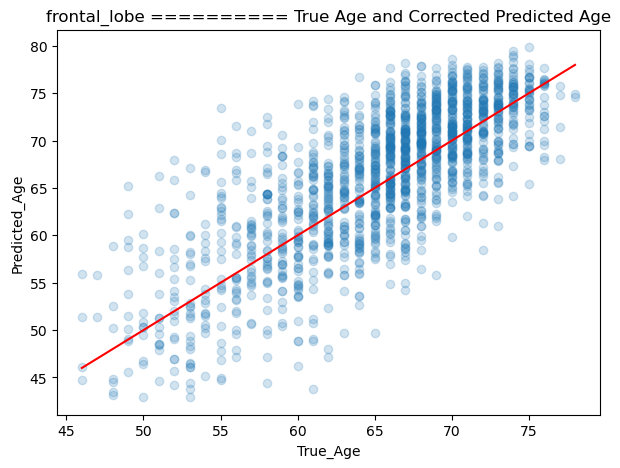

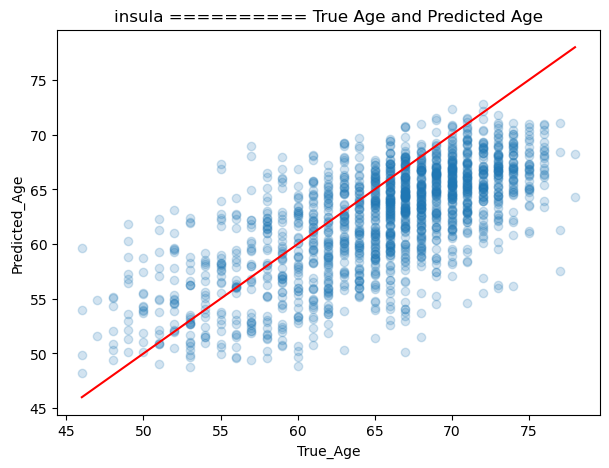

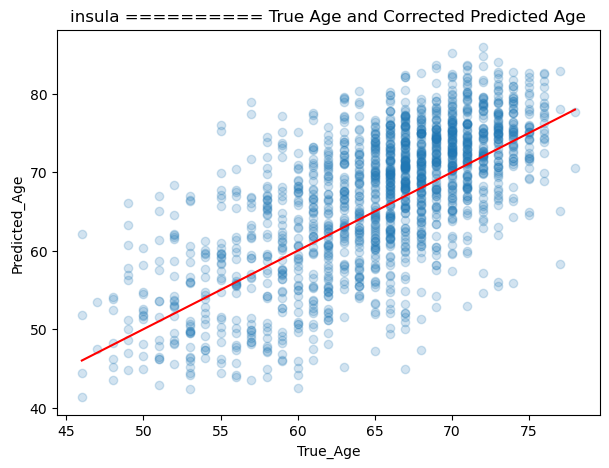

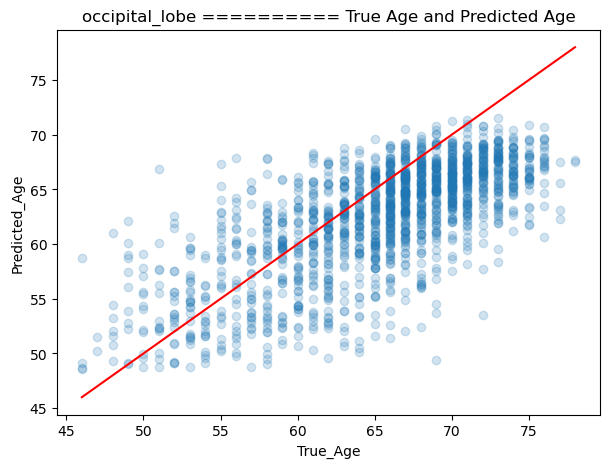

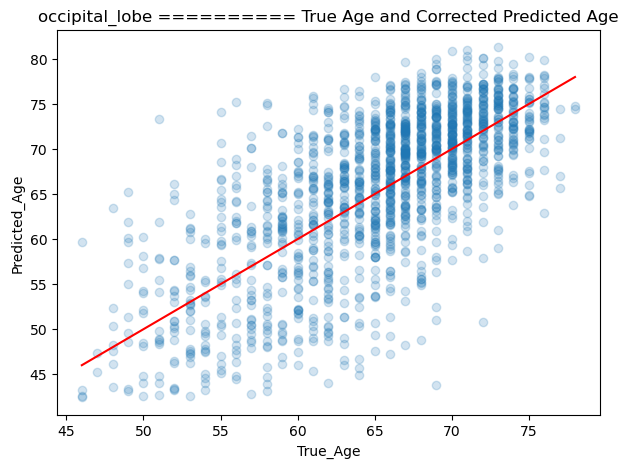

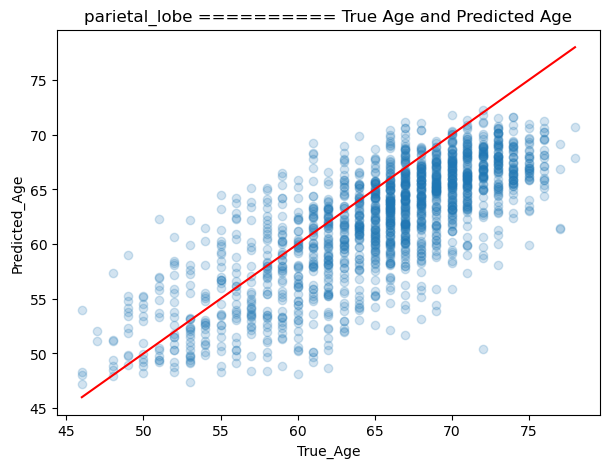

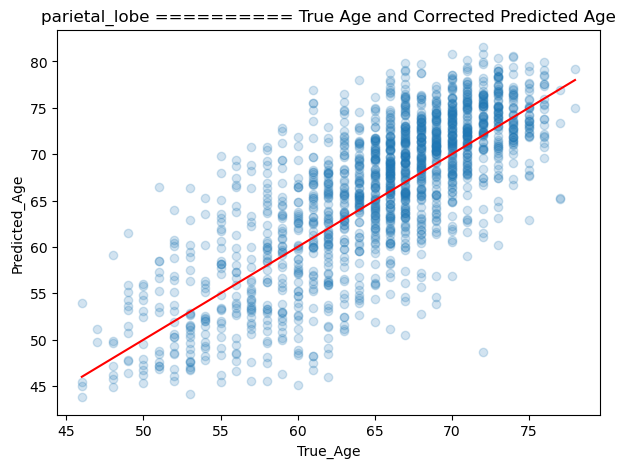

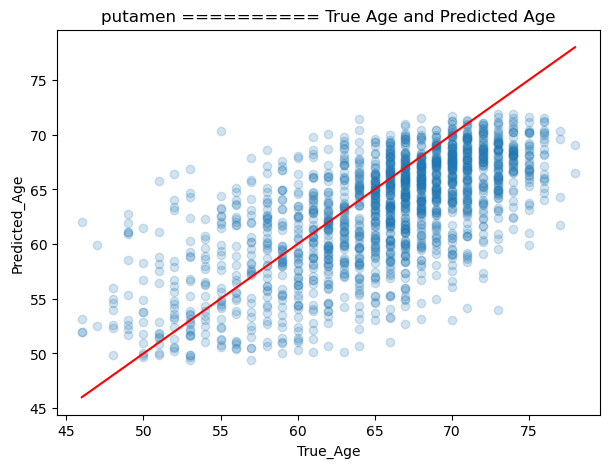

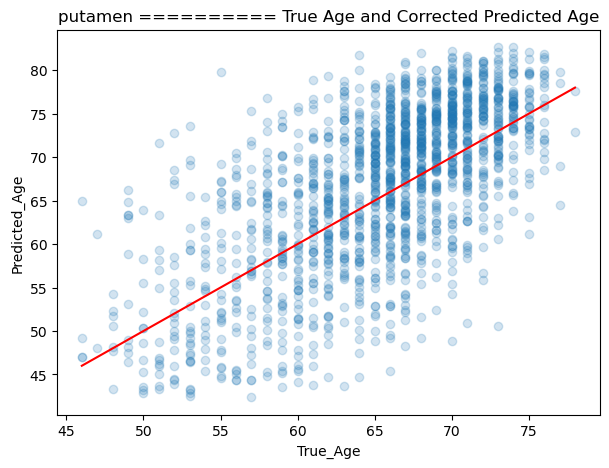

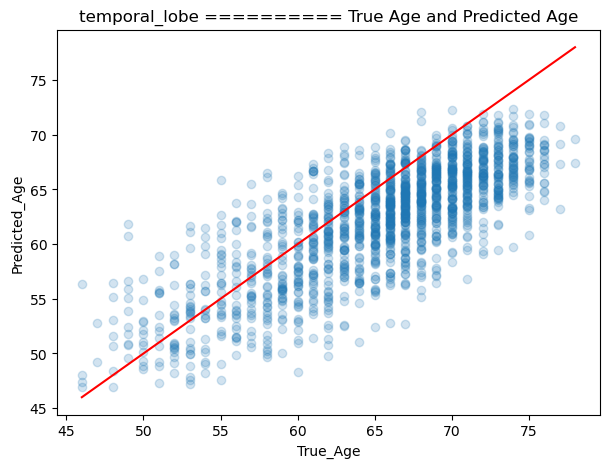

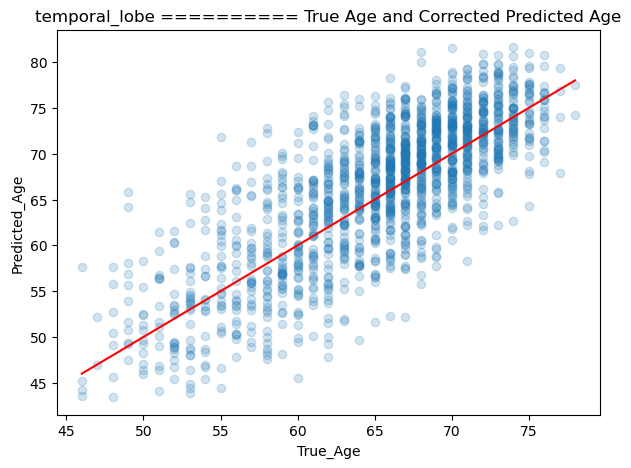

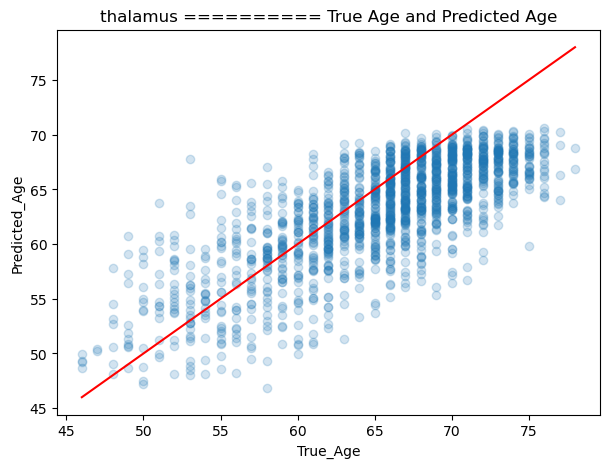

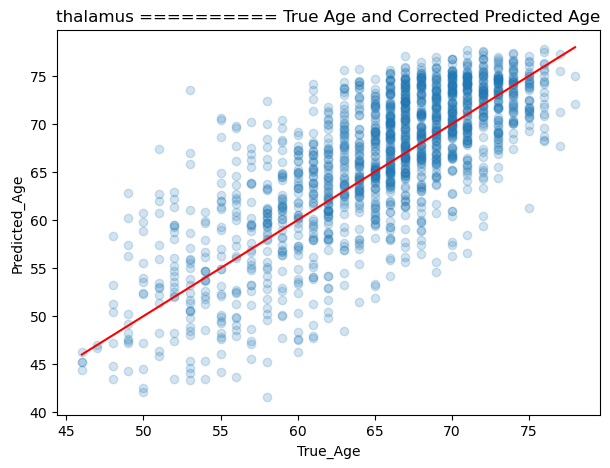

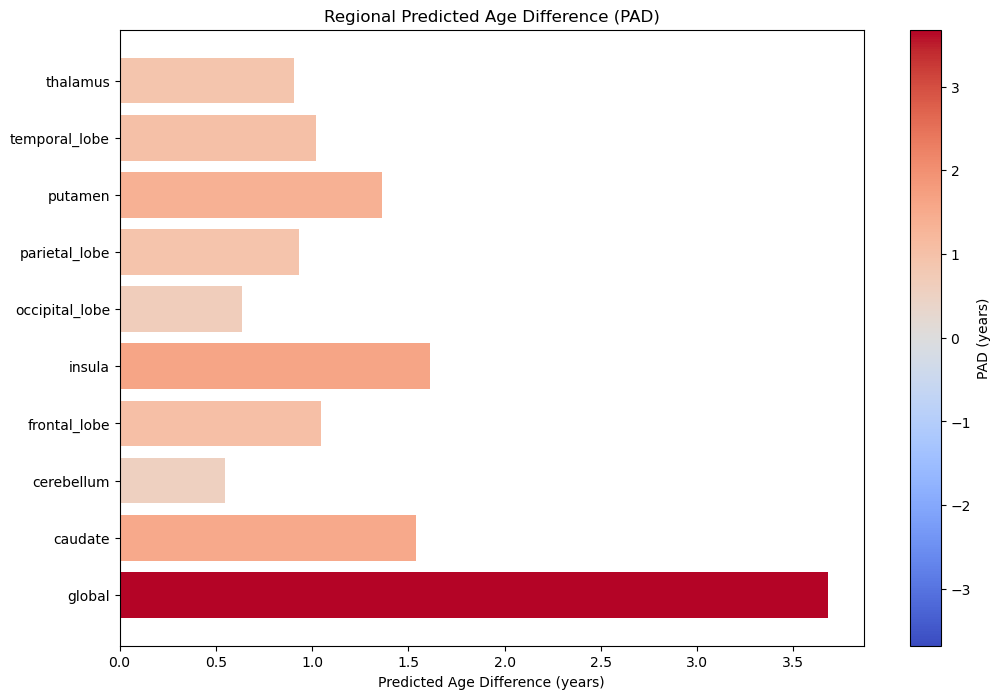

In [36]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups[disease_u] = dict()

for key, region in regions.items():
    region_n = region
    if region == 'imgs':
        region_n = 'global'
    age_plot(disease_ages, region)
    age_plot_corrected(disease_ages, region)
    age_diff_dict[region_n] = calculate_corrected_age_diff_avg(disease_ages,region)
    age_diff_groups[disease_u][region_n] = age_diff_dict[region_n]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Regional Predicted Age Difference (PAD) by Group

In [37]:
age_diff_dict

{'global': 3.6803289,
 'caudate': 1.5370474,
 'cerebellum': 0.5473002,
 'frontal_lobe': 1.0482896,
 'insula': 1.610633,
 'occipital_lobe': 0.6334205,
 'parietal_lobe': 0.9326416,
 'putamen': 1.3611603,
 'temporal_lobe': 1.021598,
 'thalamus': 0.9075735}

In [38]:
age_diff_groups

{'CN': {'global': -0.2302331,
  'caudate': -0.0961556,
  'cerebellum': -0.0342404,
  'frontal_lobe': -0.0655813,
  'insula': -0.1007682,
  'occipital_lobe': -0.0396275,
  'parietal_lobe': -0.0583432,
  'putamen': -0.0851573,
  'temporal_lobe': -0.0639032,
  'thalamus': -0.0567728},
 'E780': {'global': 3.6803289,
  'caudate': 1.5370474,
  'cerebellum': 0.5473002,
  'frontal_lobe': 1.0482896,
  'insula': 1.610633,
  'occipital_lobe': 0.6334205,
  'parietal_lobe': 0.9326416,
  'putamen': 1.3611603,
  'temporal_lobe': 1.021598,
  'thalamus': 0.9075735}}

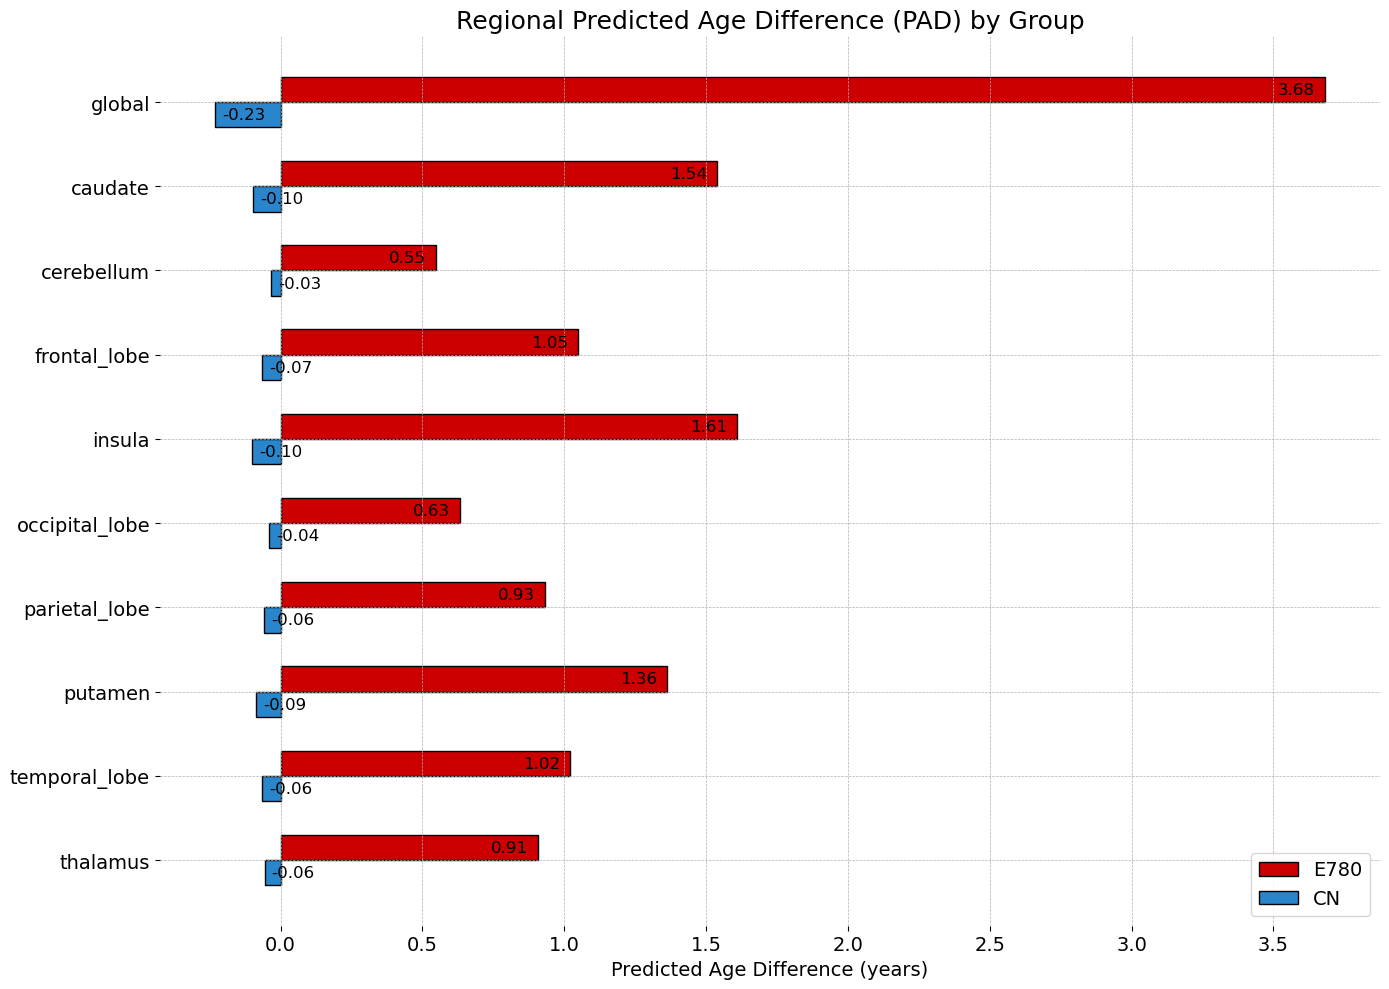

In [39]:
# 시각화

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(14, 10))

    colors = {
        'CN': '#2986cc',   
        disease_u: '#cc0000'    
    }

    bar_width = 0.3  
    index = np.arange(len(regions))

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions, fontsize=14)
    ax.set_xlabel('Predicted Age Difference (years)', fontsize=14)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group', fontsize=18)
    # 범례 순서 뒤집기
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize=14)
    
    # x축 눈금 폰트 크기 설정
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()

regions_l = list(regions.values())
regions_l.pop(0)
regions_l.insert(0, 'global')
regions_l = regions_l[::-1]
multi_group_age_diff_plot(age_diff_groups, ['CN', disease_u], regions_l)

# 통계 확인

In [192]:
# Dictionary to store Welch's t-test results for each region
t_test_results = {}

for _, region in regions.items():
    # Calculate the predicted age difference (PAD) for each individual in both groups
    pad_mci = np.array(disease_ages[region]['corrected_pred_ages']) - np.array(disease_ages[region]['true_ages'])
    pad_ad = np.array(adni_ad_ages[region]['corrected_pred_ages']) - np.array(adni_ad_ages[region]['true_ages'])

    print(pad_mci.shape, pad_ad.shape)
    # Levene's Test 수행
    stat, p_value = stats.levene(pad_mci, pad_ad)
    levene_test_results[region] = {'stat': stat, 'p_value': p_value}
    
    # p-값이 유의수준보다 작으면 (예: 0.05) 분산이 다르다고 결론 내립니다.
    if p_value < 0.05:
        print("두 그룹의 분산이 다릅니다.")
    else:
        print("두 그룹의 분산이 같습니다.")
        # Perform t-test to compare the two groups
        t_stat, p_value = stats.ttest_ind(pad_mci, pad_ad)
        if p_value < 0.05:
            print("significant")
        else:
            print("Not significant")
        
        # Store the results
        t_test_results[region] = {'t_stat': t_stat, 'p_value': p_value, 'avg_pad_mci': np.round(np.mean(pad_mci), 7), 'avg_pad_ad': np.round(np.mean(pad_ad), 7)}
    print("="*30)
pd.DataFrame(t_test_results)

(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant
(812,) (261,)
두 그룹의 분산이 같습니다.
significant


imgs       caudate  cerebellum  frontal_lobe  \
t_stat      -9.621312e+00 -6.395897e+00   -3.517007 -7.486780e+00   
p_value      4.492453e-21  2.379878e-10    0.000455  1.470627e-13   
avg_pad_mci  7.232955e-01  6.701883e-01    0.904890  7.332923e-01   
avg_pad_ad   5.508343e+00  5.748757e+00    3.196512  5.408245e+00   

                   insula  occipital_lobe  parietal_lobe   putamen  \
t_stat      -7.711948e+00   -6.851631e+00  -8.409461e+00 -4.229427   
p_value      2.822258e-14    1.229473e-11   1.301116e-16  0.000025   
avg_pad_mci  9.432560e-01    8.680322e-01   8.299474e-01  1.137367   
avg_pad_ad   8.126231e+00    5.831504e+00   6.811572e+00  5.407213   

             temporal_lobe      thalamus  
t_stat       -1.196469e+01 -6.802663e+00  
p_value       4.697560e-31  1.704983e-11  
avg_pad_mci   8.619856e-01  1.207377e+00  
avg_pad_ad    8.158850e+00  6.601501e+00

In [193]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import qsturng

anova_results = {}
levene_test_results_anova = {}
for _, region in regions.items():
    region_n = region
    if region == 'imgs':
        region_n = 'global'
    print("Current region: ", region_n)
    print("Groups: CN, MCI, AD")

    pad_cn = np.array(cn_ages[region]['corrected_pred_ages']) - np.array(cn_ages[region]['true_ages'])
    pad_mci = np.array(disease_ages[region]['corrected_pred_ages']) - np.array(disease_ages[region]['true_ages'])
    pad_ad = np.array(adni_ad_ages[region]['corrected_pred_ages']) - np.array(adni_ad_ages[region]['true_ages'])

    print(pad_cn.shape, pad_mci.shape, pad_ad.shape)
    # Levene's Test 수행
    stat, p_value_levene = stats.levene(pad_cn, pad_mci, pad_ad)
    levene_test_results_anova[region] = {'stat': stat, 'p_value': p_value_levene}
    
    # ANOVA 또는 Welch's ANOVA 수행
    if p_value_levene > 0.05:
        # 분산이 동일한 경우
        print("등분산 -> ANOVA를 수행")
        f_stat, p_value_anova = stats.f_oneway(pad_cn, pad_mci, pad_ad)
        print(f"ANOVA F-통계량: {f_stat}")
        print(f"ANOVA p-값: {p_value_anova}")
        
        # 사후 검정 (Tukey's HSD)
        data = np.concatenate([pad_cn, pad_mci, pad_ad])
        labels = ['CN'] * len(pad_cn) + ['MCI'] * len(pad_mci) + ['AD'] * len(pad_ad)
        tukey_result = pairwise_tukeyhsd(endog=data, groups=labels, alpha=0.05)
        print(tukey_result)
    else:
        # 분산이 동일하지 않은 경우
        print("등분산 아님 -> Welch's ANOVA를 수행")
        data = np.concatenate([pad_cn, pad_mci, pad_ad])
        labels = ['CN'] * len(pad_cn) + ['MCI'] * len(pad_mci) + ['AD'] * len(pad_ad)
        df = pd.DataFrame({'Value': data, 'Group': labels})
        model = sm.stats.anova_lm(sm.OLS.from_formula('Value ~ Group', df).fit(), typ=2, robust='hc3')
        print(model)
    
        # 사후 검정 (Games-Howell)
        mc = MultiComparison(df['Value'], df['Group'])
        gh_result = mc.allpairtest(stats.ttest_ind, method='holm')
        print(gh_result[0])

    print("=" * 100)

Current region:  global
Groups: CN, MCI, AD
(630,) (812,) (261,)
등분산 -> ANOVA를 수행
ANOVA F-통계량: 147.02609679714692
ANOVA p-값: 1.275086918077859e-59
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    AD     CN  -8.7226   0.0 -9.9498 -7.4954   True
    AD    MCI   -4.785   0.0 -5.9713 -3.5988   True
    CN    MCI   3.9375   0.0  3.0524  4.8227   True
---------------------------------------------------
Current region:  caudate
Groups: CN, MCI, AD
(630,) (812,) (261,)
등분산 -> ANOVA를 수행
ANOVA F-통계량: 58.83850174647414
ANOVA p-값: 1.960547402277007e-25
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
    AD     CN  -8.9941   0.0 -10.9839 -7.0044   True
    AD    MCI  -5.0786   0.0  -7.0019 -3.1552   True
    CN    MCI   3.9156   0.0   2.4804  5.3507   True
------------------------

In [195]:
pd.DataFrame(levene_test_results_anova)

imgs   caudate  cerebellum  frontal_lobe     insula  \
stat     1.041943  1.409738    9.301468      4.593691  12.258978   
p_value  0.352994  0.244492    0.000096      0.010241   0.000005   

         occipital_lobe  parietal_lobe   putamen  temporal_lobe  thalamus  
stat           8.460706       5.110977  3.947156       0.063595  8.766290  
p_value        0.000221       0.006123  0.019487       0.938387  0.000163

In [203]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import pandas as pd
import numpy as np

anova_results = []
tukey_results = []
games_howell_results = []

for _, region in regions.items():
    region_n = region
    if region == 'imgs':
        region_n = 'global'
    print("Current region: ", region_n)
    print("Groups: CN, MCI, AD")

    pad_cn = np.array(cn_ages[region]['corrected_pred_ages']) - np.array(cn_ages[region]['true_ages'])
    pad_mci = np.array(disease_ages[region]['corrected_pred_ages']) - np.array(disease_ages[region]['true_ages'])
    pad_ad = np.array(adni_ad_ages[region]['corrected_pred_ages']) - np.array(adni_ad_ages[region]['true_ages'])

    avg_pad_cn = np.mean(pad_cn)
    avg_pad_mci = np.mean(pad_mci)
    avg_pad_ad = np.mean(pad_ad)

    print(pad_cn.shape, pad_mci.shape, pad_ad.shape)
    # Levene's Test 수행
    levene_stat, p_value_levene = stats.levene(pad_cn, pad_mci, pad_ad)
    
    # ANOVA 또는 Welch's ANOVA 수행
    if p_value_levene > 0.05:
        # 분산이 동일한 경우
        print("등분산 -> ANOVA를 수행")
        f_stat, p_value_anova = stats.f_oneway(pad_cn, pad_mci, pad_ad)
        print(f"ANOVA F-통계량: {f_stat}")
        print(f"ANOVA p-값: {p_value_anova}")
        
        # 사후 검정 (Tukey's HSD)
        data = np.concatenate([pad_cn, pad_mci, pad_ad])
        labels = ['CN'] * len(pad_cn) + ['MCI'] * len(pad_mci) + ['AD'] * len(pad_ad)
        tukey_result = pairwise_tukeyhsd(endog=data, groups=labels, alpha=0.05)
        print(tukey_result)

        anova_results.append({
            'region': region_n,
            'levene_stat': levene_stat, 'levene_p_value': p_value_levene,
            'test_type': 'ANOVA',
            'f_stat': f_stat,
            'anova_p_value': p_value_anova,
            'avg_pad_cn': avg_pad_cn,
            'avg_pad_mci': avg_pad_mci,
            'avg_pad_ad': avg_pad_ad
        })
        
        for comparison in tukey_result.summary().data[1:]:
            tukey_results.append({
                'region': region_n,
                'group1': comparison[0],
                'group2': comparison[1],
                'meandiff': comparison[2],
                'p-adj': comparison[3],
                'lower': comparison[4],
                'upper': comparison[5],
                'reject': comparison[6]
            })

    else:
        # 분산이 동일하지 않은 경우
        print("등분산 아님 -> Welch's ANOVA를 수행")
        data = np.concatenate([pad_cn, pad_mci, pad_ad])
        labels = ['CN'] * len(pad_cn) + ['MCI'] * len(pad_mci) + ['AD'] * len(pad_ad)
        df = pd.DataFrame({'Value': data, 'Group': labels})
        model = sm.stats.anova_lm(sm.OLS.from_formula('Value ~ Group', df).fit(), typ=2, robust='hc3')
        print(model)
    
        # 사후 검정 (Games-Howell)
        mc = MultiComparison(df['Value'], df['Group'])
        gh_result = mc.allpairtest(stats.ttest_ind, method='holm')
        print(gh_result[0])

        anova_results.append({
            'region': region_n,
            'levene_stat': levene_stat, 'levene_p_value': p_value_levene,
            'test_type': 'Welch\'s ANOVA',
            'f_stat': model.loc['Group', 'F'],
            'anova_p_value': model.loc['Group', 'PR(>F)'],
            'avg_pad_cn': avg_pad_cn,
            'avg_pad_mci': avg_pad_mci,
            'avg_pad_ad': avg_pad_ad
        })
        
        for comparison in gh_result[0].data[1:]:
            games_howell_results.append({
                'region': region_n,
                'group1': comparison[0],
                'group2': comparison[1],
                'stat': comparison[2],
                'pval': comparison[3],
                'pval_corr': comparison[4],
                'reject': comparison[5]
            })

    print("=" * 100)

# DataFrame 생성
anova_df = pd.DataFrame(anova_results)
tukey_df = pd.DataFrame(tukey_results)
games_howell_df = pd.DataFrame(games_howell_results)


Current region:  global
Groups: CN, MCI, AD
(630,) (812,) (261,)
등분산 -> ANOVA를 수행
ANOVA F-통계량: 147.02609679714692
ANOVA p-값: 1.275086918077859e-59
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    AD     CN  -8.7226   0.0 -9.9498 -7.4954   True
    AD    MCI   -4.785   0.0 -5.9713 -3.5988   True
    CN    MCI   3.9375   0.0  3.0524  4.8227   True
---------------------------------------------------
Current region:  caudate
Groups: CN, MCI, AD
(630,) (812,) (261,)
등분산 -> ANOVA를 수행
ANOVA F-통계량: 58.83850174647414
ANOVA p-값: 1.960547402277007e-25
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
    AD     CN  -8.9941   0.0 -10.9839 -7.0044   True
    AD    MCI  -5.0786   0.0  -7.0019 -3.1552   True
    CN    MCI   3.9156   0.0   2.4804  5.3507   True
------------------------

In [204]:
anova_df

region  levene_stat  levene_p_value      test_type      f_stat  \
0          global     1.041943        0.352994          ANOVA  147.026097   
1         caudate     1.409738        0.244492          ANOVA   58.838502   
2      cerebellum     9.301468        0.000096  Welch's ANOVA   36.209917   
3    frontal_lobe     4.593691        0.010241  Welch's ANOVA   82.871804   
4          insula    12.258978        0.000005  Welch's ANOVA   75.680803   
5  occipital_lobe     8.460706        0.000221  Welch's ANOVA   71.026745   
6   parietal_lobe     5.110977        0.006123  Welch's ANOVA   95.370849   
7         putamen     3.947156        0.019487  Welch's ANOVA   37.751657   
8   temporal_lobe     0.063595        0.938387          ANOVA  207.297130   
9        thalamus     8.766290        0.000163  Welch's ANOVA   83.970815   

   anova_p_value  avg_pad_cn  avg_pad_mci  avg_pad_ad  
0   1.275087e-59   -3.214253     0.723296    5.508343  
1   1.960547e-25   -3.245390     0.670188    5.748757  
2   3.980817e-16   -2.490528     0.904889    3.196512  
3   4.543758e-35   -3.185687     0.733292    5.408245  
4   3.266015e-32   -4.582279     0.943256    8.126231  
5   2.369636e-30   -3.534712     0.868032    5.831504  
6   5.548955e-40   -3.891619     0.829947    6.811572  
7   9.084880e-17   -3.706069     1.137367    5.407213  
8   2.745311e-81   -4.491122     0.861986    8.158850  
9   1.670233e-35   -4.291009     1.207377    6.601501

In [186]:
tukey_df

region group1 group2  meandiff  p-adj    lower    upper  reject
0         global     AD     CN   -8.7226    0.0  -9.9498  -7.4954    True
1         global     AD    MCI   -4.7850    0.0  -5.9713  -3.5988    True
2         global     CN    MCI    3.9375    0.0   3.0524   4.8227    True
3        caudate     AD     CN   -8.9941    0.0 -10.9839  -7.0044    True
4        caudate     AD    MCI   -5.0786    0.0  -7.0019  -3.1552    True
5        caudate     CN    MCI    3.9156    0.0   2.4804   5.3507    True
6  temporal_lobe     AD     CN  -12.6500    0.0 -14.1355 -11.1644    True
7  temporal_lobe     AD    MCI   -7.2969    0.0  -8.7328  -5.8609    True
8  temporal_lobe     CN    MCI    5.3531    0.0   4.2817   6.4245    True

In [187]:
games_howell_df

region group1 group2     stat    pval  pval_corr  reject
0       cerebellum     AD     CN   7.5018  0.0000     0.0000    True
1       cerebellum     AD    MCI   3.5170  0.0005     0.0005    True
2       cerebellum     CN    MCI  -6.4466  0.0000     0.0000    True
3     frontal_lobe     AD     CN  12.2061  0.0000     0.0000    True
4     frontal_lobe     AD    MCI   7.4868  0.0000     0.0000    True
5     frontal_lobe     CN    MCI  -8.0209  0.0000     0.0000    True
6           insula     AD     CN  11.4827  0.0000     0.0000    True
7           insula     AD    MCI   7.7119  0.0000     0.0000    True
8           insula     CN    MCI  -7.3205  0.0000     0.0000    True
9   occipital_lobe     AD     CN  10.9242  0.0000     0.0000    True
10  occipital_lobe     AD    MCI   6.8516  0.0000     0.0000    True
11  occipital_lobe     CN    MCI  -7.4445  0.0000     0.0000    True
12   parietal_lobe     AD     CN  13.2745  0.0000     0.0000    True
13   parietal_lobe     AD    MCI   8.4095  0.0000     0.0000    True
14   parietal_lobe     CN    MCI  -8.5480  0.0000     0.0000    True
15         putamen     AD     CN   8.0423  0.0000     0.0000    True
16         putamen     AD    MCI   4.2294  0.0000     0.0000    True
17         putamen     CN    MCI  -6.1673  0.0000     0.0000    True
18        thalamus     AD     CN  11.8980  0.0000     0.0000    True
19        thalamus     AD    MCI   6.8027  0.0000     0.0000    True
20        thalamus     CN    MCI  -8.6485  0.0000     0.0000    True

-2.7328699


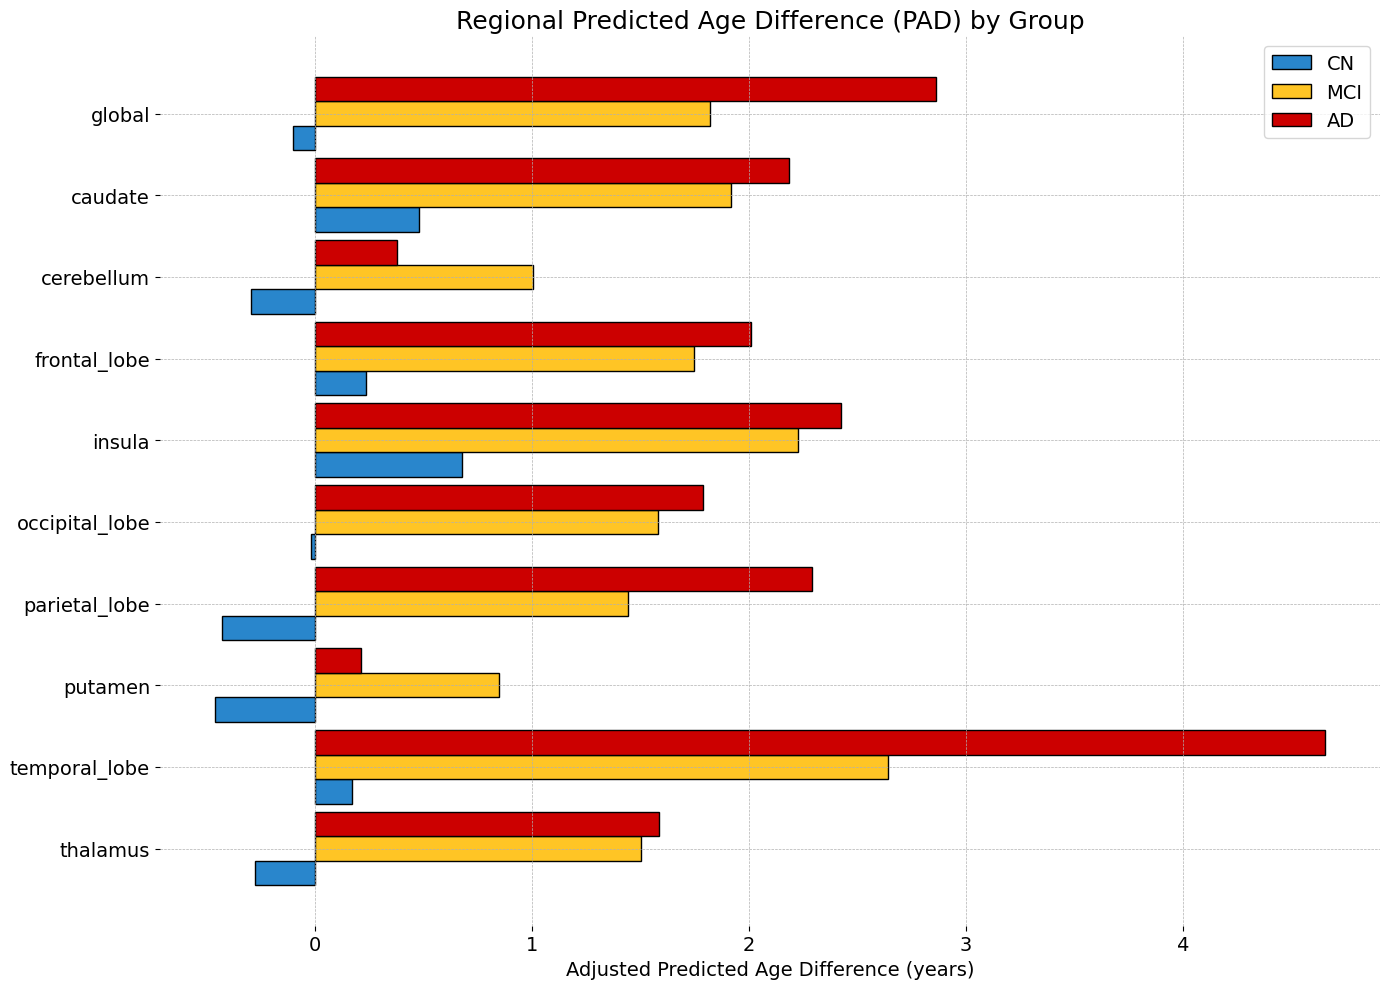

In [154]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_groups['CN'][region] = calculate_age_diff_avg(cn_ages, region)
    cn_stats[region] = age_diff_groups['CN'][region]
    
    age_diff_groups['MCI'][region] = calculate_age_diff_avg(disease_ages, region)
    age_diff_groups['AD'][region] = calculate_age_diff_avg(adni_ad_ages, region)



# 'CN' 그룹의 평균 차이 계산
cn_mean = np.mean([val for val in age_diff_groups['CN'].values()]) 
print(cn_mean)

# 'CN' 그룹의 평균 차이를 다른 그룹의 값에 더하는 함수
def adjust_with_cn_mean(age_diff_dict, cn_mean):
    adjusted_dict = {}
    for group, regions in age_diff_dict.items():
        adjusted_dict[group] = {region: val - cn_mean for region, val in regions.items()}
    return adjusted_dict

adjusted_age_diff_groups = adjust_with_cn_mean(age_diff_groups, cn_mean)

def adjusted_multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(14, 10))

    # 그룹별 색상 설정 (직접 RGB 값 사용)
    colors = {
        'CN': '#2986cc',    # 정상군
        'MCI': '#ffc525',  # 경도인지장애군
        'AD': '#cc0000'    # 치매군
    }

    bar_width = 0.3  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            # ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
            #         va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions, fontsize=14)
    ax.set_xlabel('Adjusted Predicted Age Difference (years)', fontsize=14)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group', fontsize=18)
    ax.legend(fontsize=14)
    
    # x축 눈금 폰트 크기 설정
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()


for group in ['CN', 'MCI', 'AD']:
    adjusted_age_diff_groups[group]['global'] = adjusted_age_diff_groups[group]['imgs']
    adjusted_age_diff_groups[group].pop('imgs')
regions_l = list(regions.values())
regions_l.pop(0)
regions_l.insert(0, 'global')
regions_l = regions_l[::-1]
# 시각화
adjusted_multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'MCI', 'AD'], regions_l)

imgs 630 630 630
caudate 630 630 630
cerebellum 630 630 630
frontal_lobe 630 630 630
insula 630 630 630
occipital_lobe 630 630 630
parietal_lobe 630 630 630
putamen 630 630 630
temporal_lobe 630 630 630
thalamus 630 630 630
imgs 812 812 812
caudate 812 812 812
cerebellum 812 812 812
frontal_lobe 812 812 812
insula 812 812 812
occipital_lobe 812 812 812
parietal_lobe 812 812 812
putamen 812 812 812
temporal_lobe 812 812 812
thalamus 812 812 812
imgs 261 261 261
caudate 261 261 261
cerebellum 261 261 261
frontal_lobe 261 261 261
insula 261 261 261
occipital_lobe 261 261 261
parietal_lobe 261 261 261
putamen 261 261 261
temporal_lobe 261 261 261
thalamus 261 261 261
-2.7328699


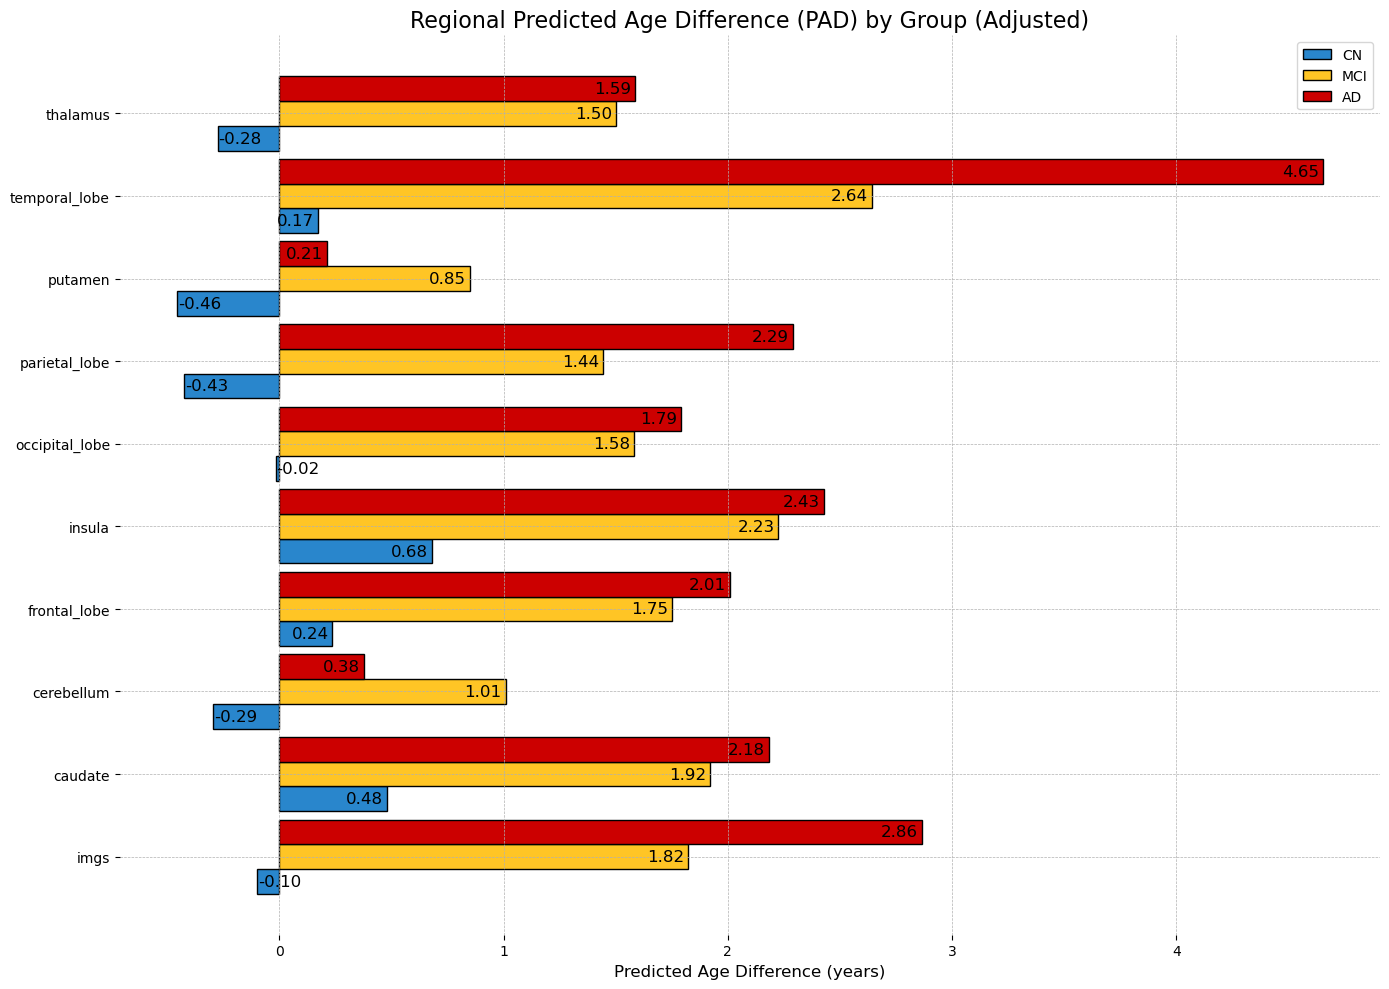

In [86]:
def pickle_load(root, cn=False, alpha=1.0):
    map = {v: {'pred_ages': [], 'true_ages': []} for _, v in regions.items()}

    # true_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickel_path = os.path.join(root, str(cv_num), 'true_ages.pkl')
        if os.path.exists(pickel_path):
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file)  # cv-split size의 dict (region: age_lists)  # age_lists length: 630
                for region, age_list in curr_cv.items():
                    if cn == False:
                        map[region]['true_ages'] = age_list
                    else:
                        map[region]['true_ages'].extend(age_list)
    
    # pred_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickle_path = os.path.join(root, str(cv_num), 'pred_ages.pkl')
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                curr_cv = pickle.load(file)
                for region, age_list in curr_cv.items():
                    if cn == False:
                        map[region]['pred_ages'].append(age_list)
                    else:
                        map[region]['pred_ages'].extend(age_list)

    # 평균
    if cn == False:
        for region, _ in map.items():
            map[region].setdefault('corrected_pred_ages', [])
            pred_ages_lists = map[region]['pred_ages']
            for pred in pred_ages_lists:
                true = map[region]['true_ages']
                # corrected_pred = bias_correction_with_penalty(true, pred, alpha) 
                # corrected_pred = bias_correction(np.array(true), np.array(pred))
                corrected_pred = bias_correction_standard(np.array(true), np.array(pred))
                map[region]['corrected_pred_ages'].append(corrected_pred)
            pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
            map[region]['pred_ages'] = pred_avg_age

            corrected_pred_ages_lists = map[region]['corrected_pred_ages']
            corrected_pred_avg_age = [sum(values) / len(values) for values in zip(*corrected_pred_ages_lists)]
            map[region]['corrected_pred_ages'] = corrected_pred_avg_age

            print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    else:
        for region, age_list in map.items():
            pred = np.array(map[region]['pred_ages'])
            true = np.array(map[region]['true_ages'])
            # map[region]['corrected_pred_ages'] = bias_correction_with_penalty(true, pred, alpha)
            map[region]['corrected_pred_ages'] = bias_correction_standard(true, pred)
            print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))


    print("=" * 30)
    return map          


cn_root = root + 'adni_cn_tf'
cn_ages = pickle_load(cn_root, True, alpha_cn)
mci_root = root + 'adni_mci_tf'
disease_ages = pickle_load(mci_root, False, alpha_mci)
ad_root = root + 'adni_ad_tf'
adni_ad_ages = pickle_load(ad_root, False, alpha_ad)

# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_groups['CN'][region] = calculate_age_diff_avg(cn_ages, region)
    cn_stats[region] = age_diff_groups['CN'][region]
    
    age_diff_groups['MCI'][region] = calculate_age_diff_avg(disease_ages, region)
    age_diff_groups['AD'][region] = calculate_age_diff_avg(adni_ad_ages, region)



# 'CN' 그룹의 평균 차이 계산
cn_mean = np.mean([val for val in age_diff_groups['CN'].values()]) 
print(cn_mean)

# 'CN' 그룹의 평균 차이를 다른 그룹의 값에 더하는 함수
def adjust_with_cn_mean(age_diff_dict, cn_mean):
    adjusted_dict = {}
    for group, regions in age_diff_dict.items():
        adjusted_dict[group] = {region: val - cn_mean for region, val in regions.items()}
        # if group == 'CN':
        #     adjusted_dict[group] = regions
        # else:
        #     adjusted_dict[group] = {region: val - cn_means[region] for region, val in regions.items()}
    return adjusted_dict

adjusted_age_diff_groups = adjust_with_cn_mean(age_diff_groups, cn_mean)

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(14, 10))

    # 그룹별 색상 설정 (seaborn 팔레트 사용)
    colors = {
        'CN': '#2986cc',    # 정상군
        'MCI': '#ffc525',  # 경도인지장애군
        'AD': '#cc0000'      # 치매군
    }

    bar_width = 0.3  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)', fontsize=12)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group (Adjusted)', fontsize=16)
    ax.legend()
    
    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()

# 시각화
multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'MCI', 'AD'], regions.values())

In [140]:
import numpy as np

def calculate_age_diff_statistics(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = pred_ages - true_ages
    return np.mean(diff), np.std(diff)

cn_root = root + 'adni_cn_tf'
cn_ages = pickle_load(cn_root, True, alpha_cn)
mci_root = root + 'adni_mci_tf'
disease_ages = pickle_load(mci_root, False, alpha_mci)
ad_root = root + 'adni_ad_tf'
adni_ad_ages = pickle_load(ad_root, False, alpha_ad)

# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_groups['CN'][region] = calculate_age_diff_statistics(cn_ages, region)
    cn_stats[region] = age_diff_groups['CN'][region]
    
    age_diff_groups['MCI'][region] = calculate_age_diff_statistics(disease_ages, region)
    age_diff_groups['AD'][region] = calculate_age_diff_statistics(adni_ad_ages, region)

print(cn_stats)

# def adjust_disease_group_with_cn_stats(age_diff_dict, cn_stats):
#     adjusted_dict = {}
#     for group in age_diff_dict:
#         if group == 'CN':
#             adjusted_dict[group] = age_diff_dict[group]
#         else:
#             adjusted_dict[group] = {}
#             for region in age_diff_dict[group]:
#                 pred_ages = np.array(age_diff_dict[group][region]['pred_ages'])
#                 true_ages = np.array(age_diff_dict[group][region]['true_ages'])
#                 diff = pred_ages - true_ages
                
#                 cn_mean, cn_var = cn_stats[region]
#                 adjusted_diff = (diff - cn_mean) / np.sqrt(cn_var)
                
#                 adjusted_dict[group][region] = {
#                     'pred_ages': pred_ages,
#                     'true_ages': true_ages,
#                     'adjusted_diff': adjusted_diff
#                 }
#     return adjusted_dict

# adjusted_age_diff_groups = adjust_disease_group_with_cn_stats(age_diff_groups, cn_stats)



# import matplotlib.pyplot as plt
# import seaborn as sns

# def multi_group_age_diff_plot(age_diff_dict, groups, regions):
#     fig, ax = plt.subplots(figsize=(14, 10))

#     # 그룹별 색상 설정 (seaborn 팔레트 사용)
#     colors = {
#         'CN': '#2986cc',    # 정상군
#         'MCI': '#ffc525',  # 경도인지장애군
#         'AD': '#cc0000'    # 치매군
#     }

#     bar_width = 0.3  # 막대의 너비
#     index = np.arange(len(regions))  # 지역 인덱스

#     # 각 그룹에 대해 조정된 PAD 값을 시각화
#     for i, group in enumerate(groups):
#         pad_values = [np.mean(age_diff_dict[group][region]['adjusted_diff']) for region in regions]
#         bar_positions = index + i * bar_width
        
#         bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
#         # 막대에 값 표시 (애너테이션)
#         for bar in bars:
#             width = bar.get_width()
#             label_x_pos = width + 0.1 if width < 0 else width - 0.1
#             ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
#                     va='center', ha='center', color='black', fontsize=12)

#     # y축 정렬 및 스타일 설정
#     ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
#     ax.set_yticklabels(regions)
#     ax.set_xlabel('Adjusted Predicted Age Difference (years)', fontsize=12)
#     ax.set_title('Regional Predicted Age Difference (PAD) by Group (Adjusted)', fontsize=16)
#     ax.legend()
    
#     # 그리드와 스타일 설정
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     sns.despine(left=True, bottom=True)
    
#     # 여백 조정
#     plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
#     plt.show()

# # 시각화
# multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'MCI', 'AD'], regions.values())

imgs 630 630 630
caudate 630 630 630
cerebellum 630 630 630
frontal_lobe 630 630 630
insula 630 630 630
occipital_lobe 630 630 630
parietal_lobe 630 630 630
putamen 630 630 630
temporal_lobe 630 630 630
thalamus 630 630 630
imgs 812 812 812
caudate 812 812 812
cerebellum 812 812 812
frontal_lobe 812 812 812
insula 812 812 812
occipital_lobe 812 812 812
parietal_lobe 812 812 812
putamen 812 812 812
temporal_lobe 812 812 812
thalamus 812 812 812
imgs 261 261 261
caudate 261 261 261
cerebellum 261 261 261
frontal_lobe 261 261 261
insula 261 261 261
occipital_lobe 261 261 261
parietal_lobe 261 261 261
putamen 261 261 261
temporal_lobe 261 261 261
thalamus 261 261 261
{'imgs': (-2.8326538, 4.930282), 'caudate': (-2.252532, 6.12684), 'cerebellum': (-3.027125, 5.845529), 'frontal_lobe': (-2.4966223, 5.6130958), 'insula': (-2.052481, 6.5064144), 'occipital_lobe': (-2.7490838, 6.132413), 'parietal_lobe': (-3.158127, 5.933514), 'putamen': (-3.1901648, 6.5912557), 'temporal_lobe': (-2.5613346, 5.

In [72]:
import numpy as np

# 각 지역에 대한 예측 연령 차이 계산
def calculate_age_diff_avg(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = pred_ages - true_ages
    return np.mean(diff)

# 예시 데이터 초기화
age_diff_groups = {'CN': {}, 'MCI': {}, 'AD': {}}

# CN 그룹
for region in regions:
    age_diff_groups['CN'][region] = {
        'pred_ages': cn_ages[region]['pred_ages'],
        'true_ages': cn_ages[region]['true_ages']
    }

# MCI 그룹
for region in regions:
    age_diff_groups['MCI'][region] = {
        'pred_ages': disease_ages[region]['pred_ages'],
        'true_ages': disease_ages[region]['true_ages']
    }

# AD 그룹
for region in regions:
    age_diff_groups['AD'][region] = {
        'pred_ages': adni_ad_ages[region]['pred_ages'],
        'true_ages': adni_ad_ages[region]['true_ages']
    }

# 'CN' 그룹의 리전별 평균과 분산 계산
def calculate_age_diff_statistics(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = pred_ages - true_ages
    return np.mean(diff), np.var(diff)

cn_stats = {}
for region in age_diff_groups['CN']:
    cn_mean, cn_var = calculate_age_diff_statistics(age_diff_groups['CN'], region)
    cn_stats[region] = (cn_mean, cn_var)

print(age_diff_groups)
print(cn_stats)

def adjust_disease_group_with_cn_stats(age_diff_dict, cn_stats):
    adjusted_dict = {}
    for group in age_diff_dict:
        adjusted_dict[group] = {}
        for region in age_diff_dict[group]:
            pred_ages = np.array(age_diff_dict[group][region]['pred_ages'])
            true_ages = np.array(age_diff_dict[group][region]['true_ages'])
            diff = pred_ages - true_ages
            
            cn_mean, cn_var = cn_stats[region]
            adjusted_diff = (diff - cn_mean) / np.sqrt(cn_var)
            
            adjusted_dict[group][region] = {
                'pred_ages': pred_ages,
                'true_ages': true_ages,
                'adjusted_diff': adjusted_diff
            }
    return adjusted_dict

adjusted_age_diff_groups = adjust_disease_group_with_cn_stats(age_diff_groups, cn_stats)


import matplotlib.pyplot as plt
import seaborn as sns

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(14, 10))

    # 그룹별 색상 설정 (seaborn 팔레트 사용)
    colors = {
        'CN': '#2986cc',    # 정상군
        'MCI': '#ffc525',  # 경도인지장애군
        'AD': '#cc0000'    # 치매군
    }

    bar_width = 0.3  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 조정된 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [np.mean(age_diff_dict[group][region]['adjusted_diff']) for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Adjusted Predicted Age Difference (years)', fontsize=12)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group (Adjusted)', fontsize=16)
    ax.legend()
    
    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    # 여백 조정
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()

# 시각화
multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'MCI', 'AD'], list(regions))

KeyError: 0

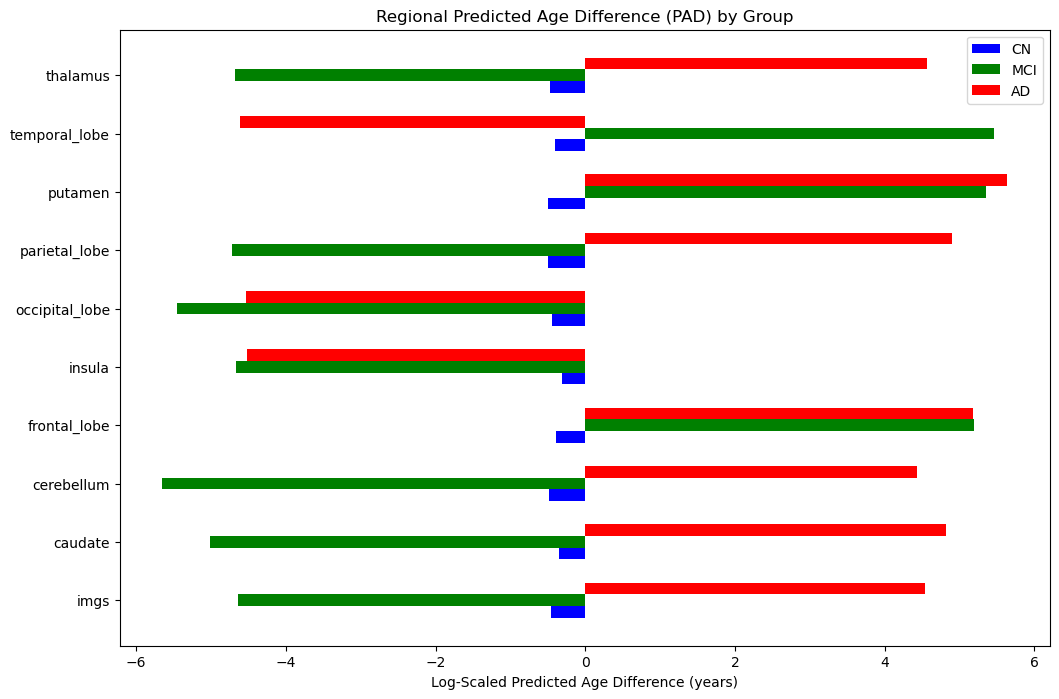

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    # 그룹별 색상 설정
    colors = {
        'CN': 'blue',
        'MCI': 'green',
        'AD': 'red'
    }

    bar_width = 0.2  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        
        # 로그 변환 적용 (값이 음수인 경우 절대값을 취한 후 로그 변환)
        pad_values = [np.log10(abs(val) + 1e-6) * np.sign(val) for val in pad_values]
        
        bar_positions = index + i * bar_width
        ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group])

    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Log-Scaled Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD) by Group')
    ax.legend()
    plt.show()

# 시각화
multi_group_age_diff_plot(age_diff_groups, ['CN', 'MCI', 'AD'], regions.values())

In [61]:
age_diff_groups['CN']

{'imgs': -4.7e-06,
 'caudate': -1.26e-05,
 'cerebellum': 1.9e-06,
 'frontal_lobe': 6.5e-06,
 'insula': -5.5e-06,
 'occipital_lobe': -1.64e-05,
 'parietal_lobe': -1.48e-05,
 'putamen': -2.3e-06,
 'temporal_lobe': -3.6e-06,
 'thalamus': 1.6e-06}

In [62]:
age_diff_groups['MCI']

{'imgs': 2.21e-05,
 'caudate': 8.6e-06,
 'cerebellum': 1.2e-06,
 'frontal_lobe': -5.4e-06,
 'insula': 2.03e-05,
 'occipital_lobe': 2.5e-06,
 'parietal_lobe': 1.8e-05,
 'putamen': -3.4e-06,
 'temporal_lobe': -2.5e-06,
 'thalamus': 1.97e-05}

In [63]:
age_diff_groups['AD']

{'imgs': -2.76e-05,
 'caudate': -1.4e-05,
 'cerebellum': -3.65e-05,
 'frontal_lobe': -5.7e-06,
 'insula': 2.91e-05,
 'occipital_lobe': 2.85e-05,
 'parietal_lobe': -1.18e-05,
 'putamen': -1.3e-06,
 'temporal_lobe': 2.37e-05,
 'thalamus': -2.64e-05}

# Age Difference Distribution

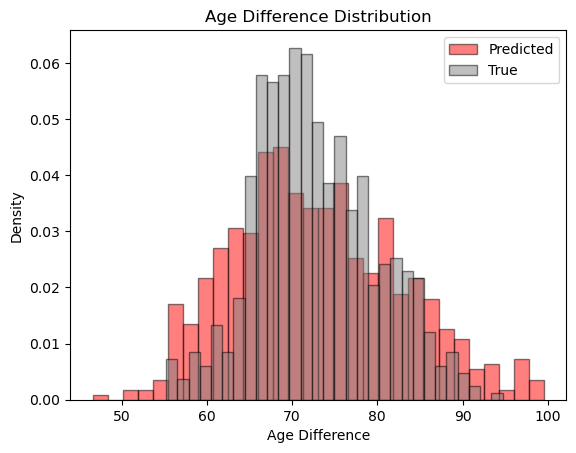

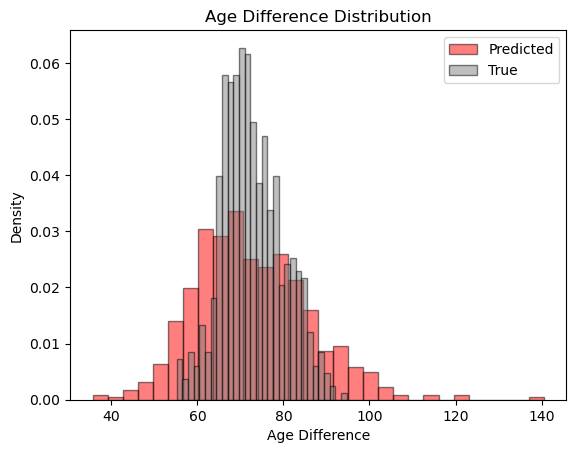

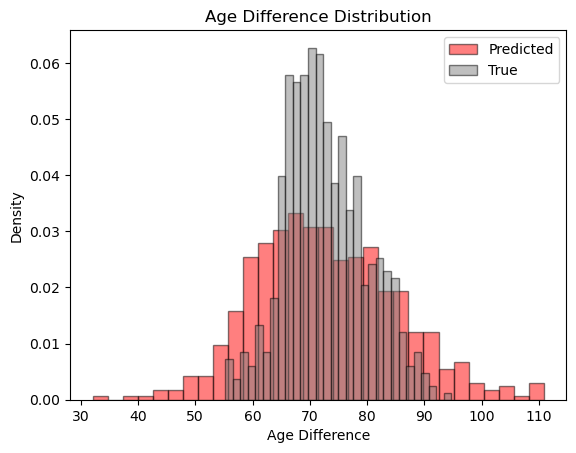

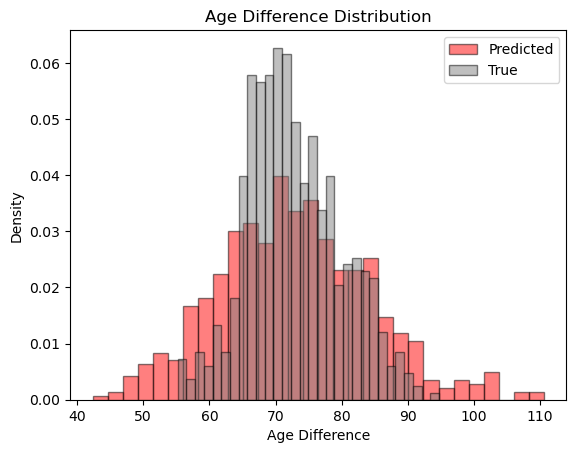

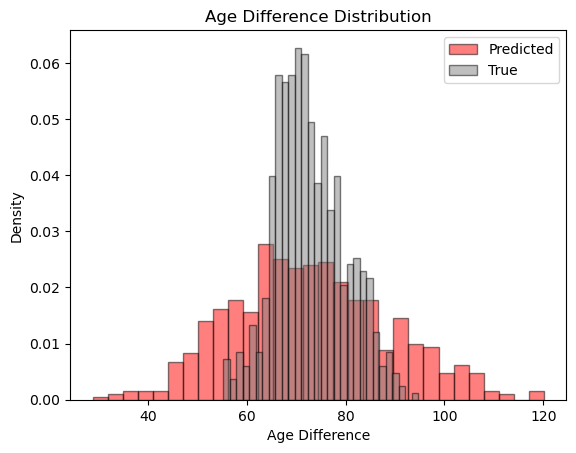

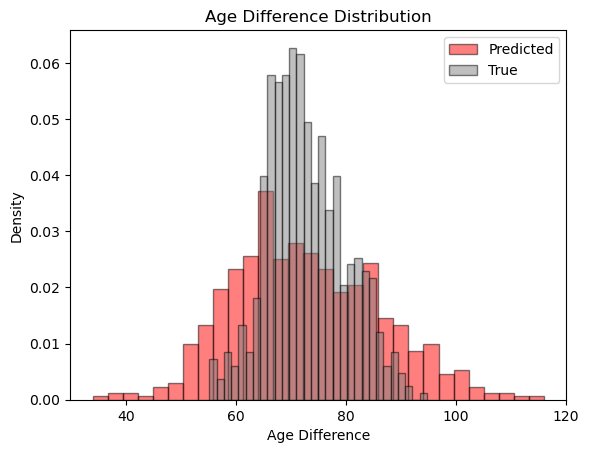

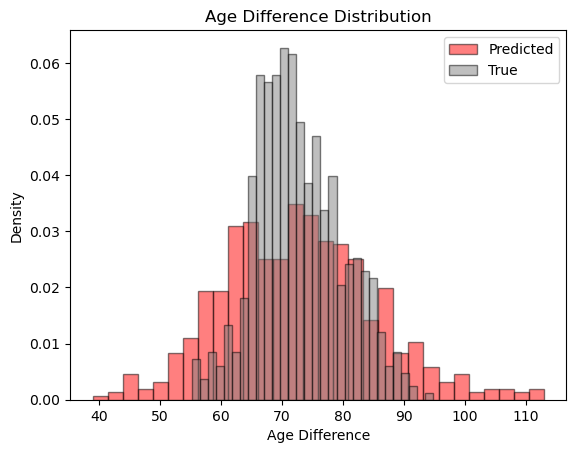

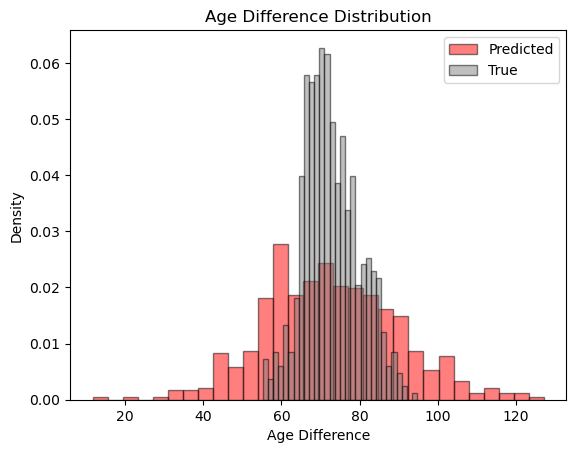

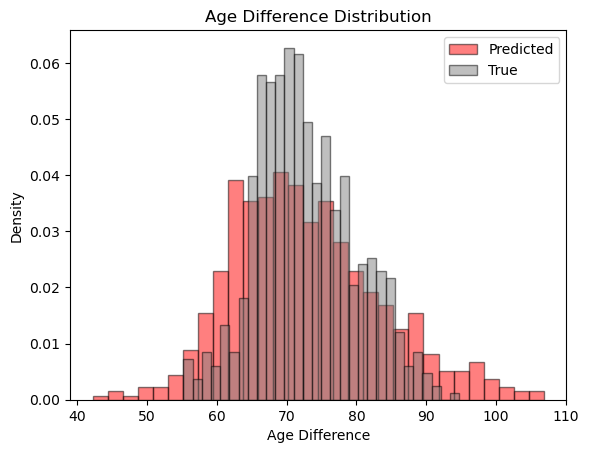

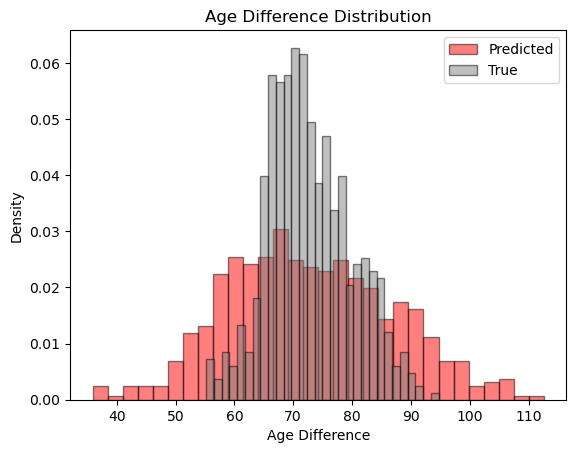

In [99]:
for key, region in regions.items():
    print(region)
    calculate_age_diff_dist(cn_ages,region)

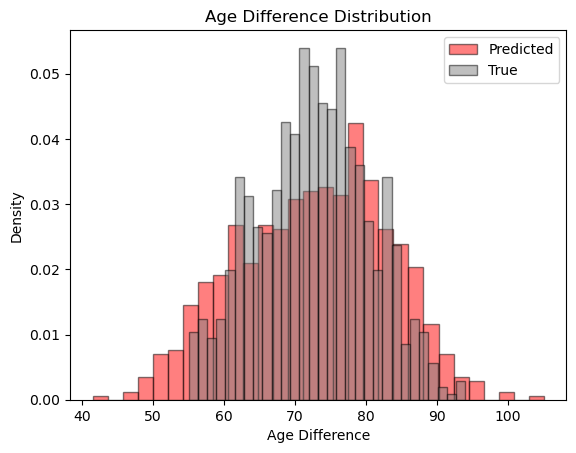

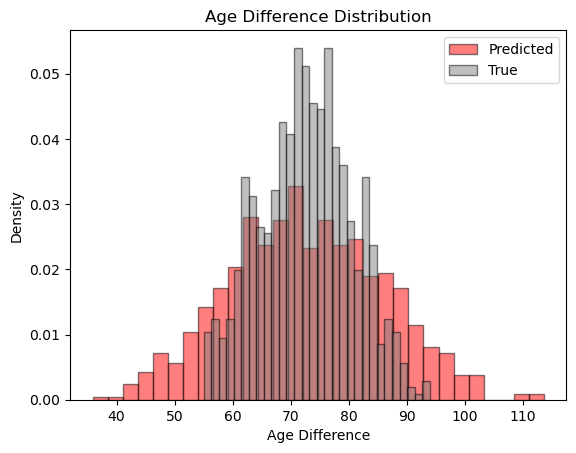

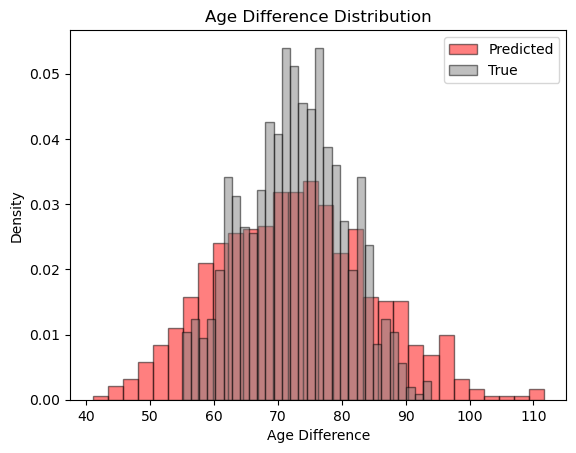

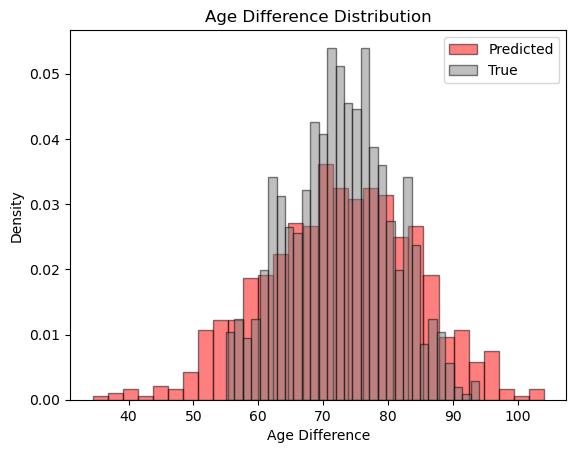

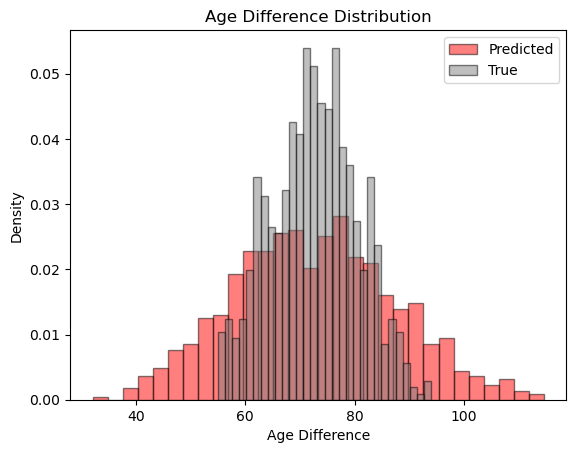

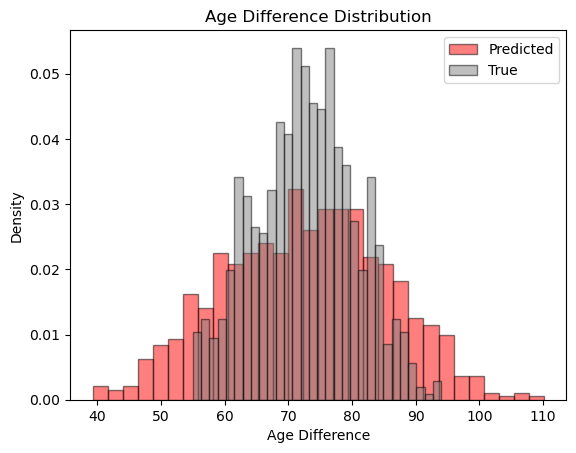

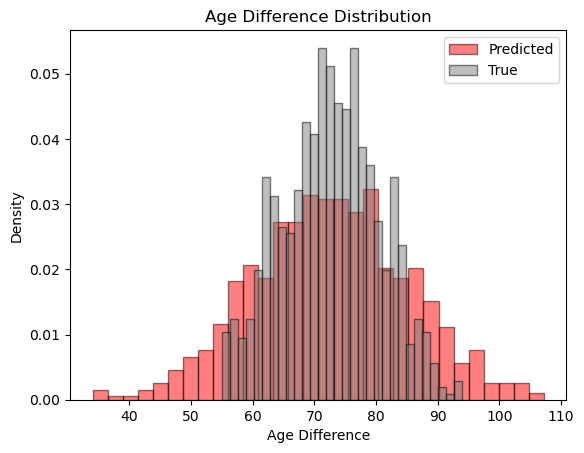

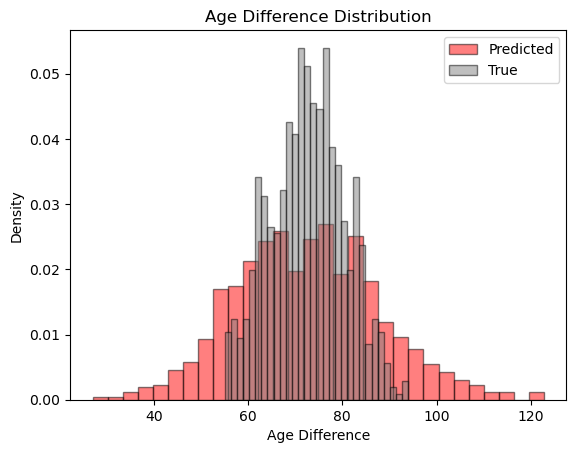

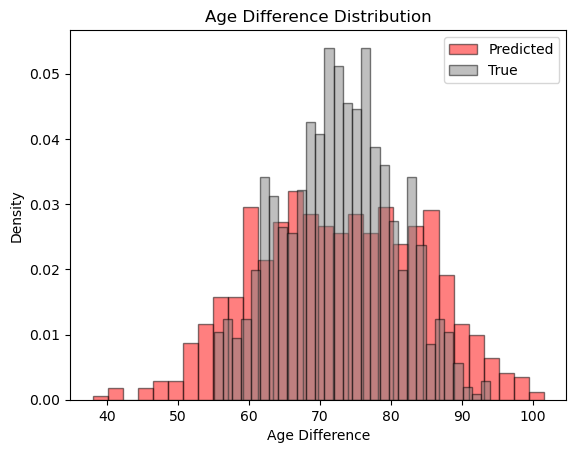

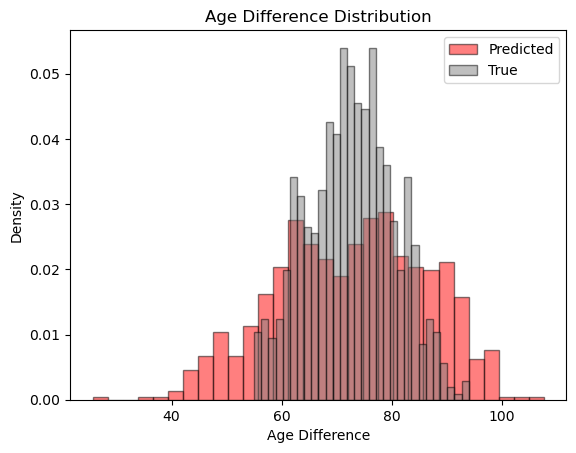

In [100]:
for key, region in regions.items():
    calculate_age_diff_dist(disease_ages,region)

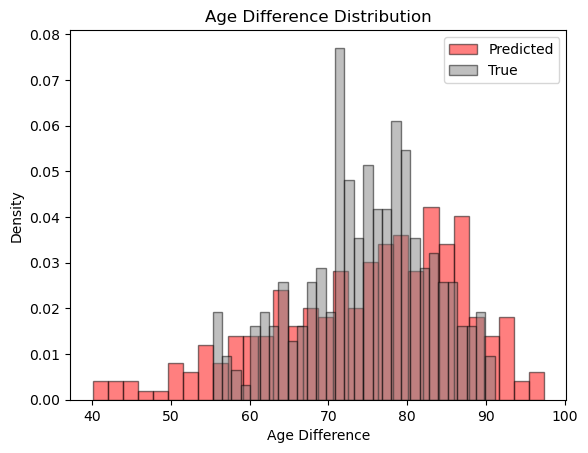

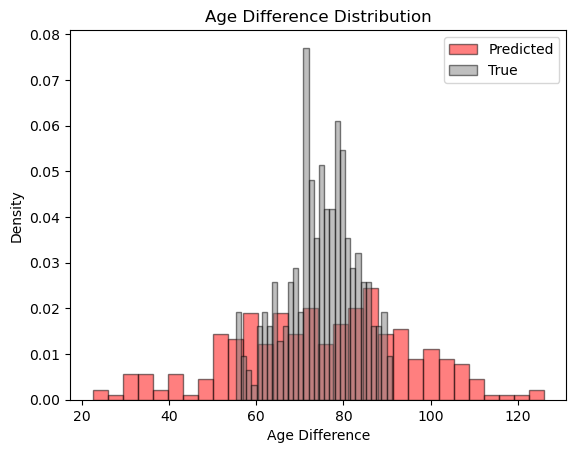

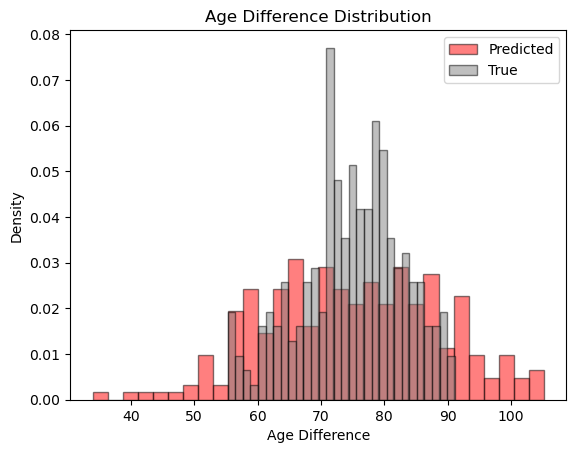

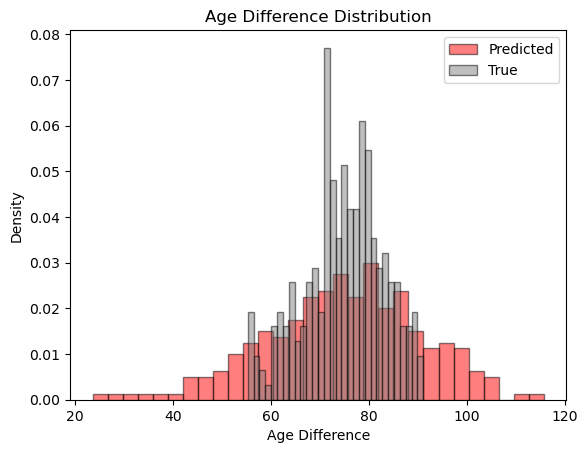

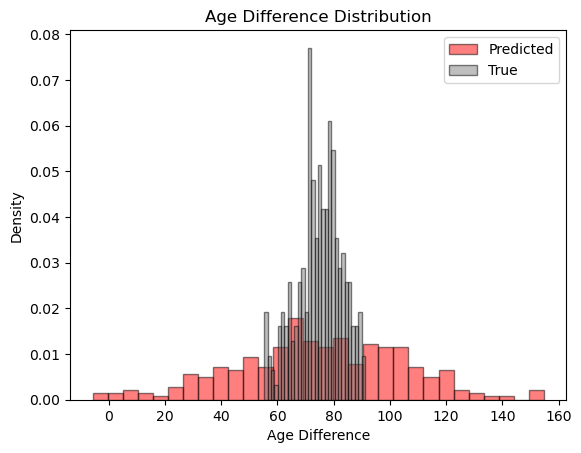

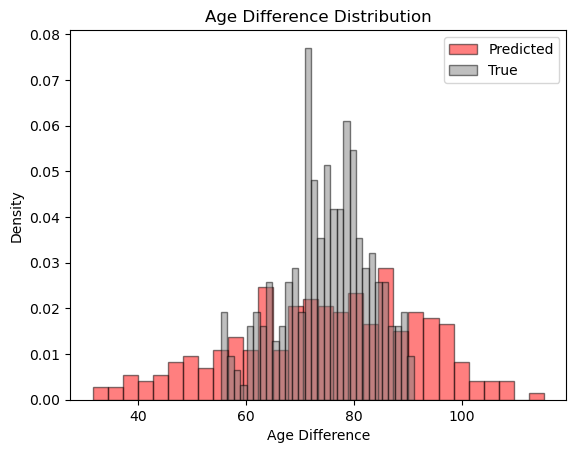

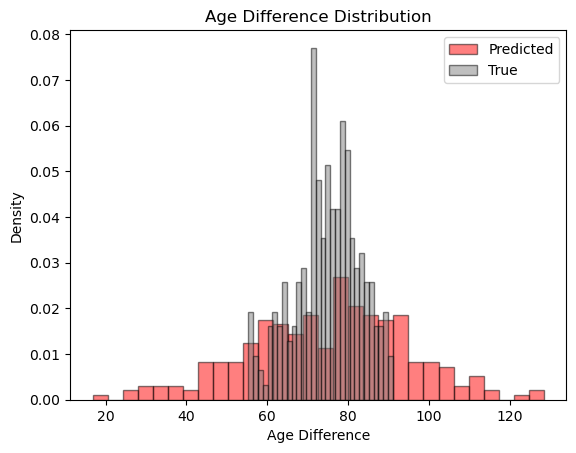

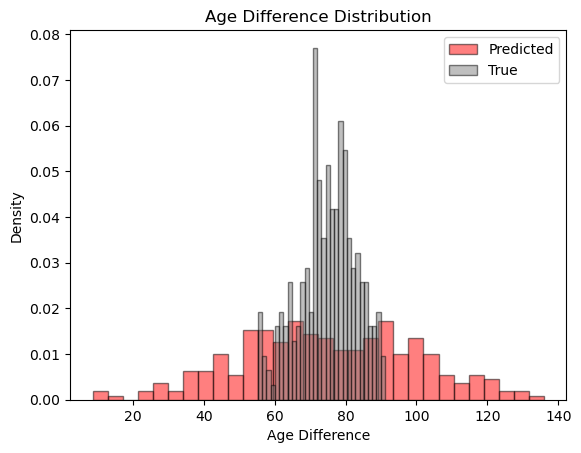

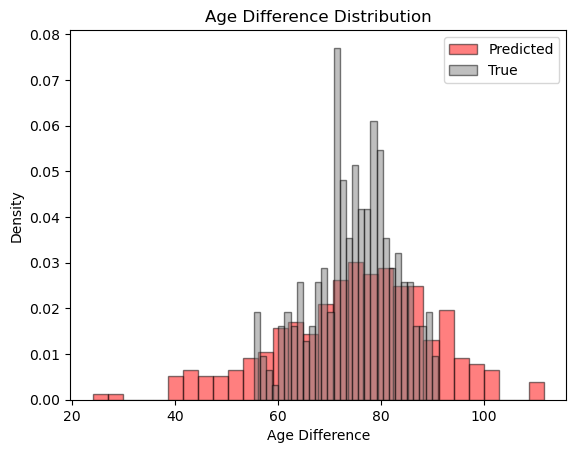

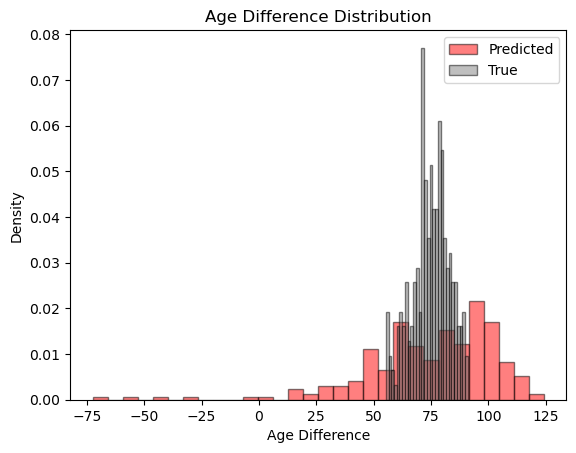

In [101]:
for key, region in regions.items():
    calculate_age_diff_dist(adni_ad_ages,region)